# Plot up some profile comparisons in the passages between deployments

#### This notebook performs the following:

1) Loads glider data<br>
2) Subsets to passage crossings<br>
3) 

## Imports

In [50]:
import pandas as pd
import math
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seawater as sw
import cmocean.cm as cmo
from scipy import integrate
from scipy.interpolate import griddata
import gsw
import sys
import matplotlib.dates as mdates
from PIL import Image
import glob
import datetime as dt
from erddapy import ERDDAP



## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/analysis/')
from analysis import gsw_rho, profile_mld, get_erddap_dataset, grid_glider_data, dist_from_lat_lon

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')



rename_argo = {}
rename_argo["platform_number"] = "argo"
rename_argo["time (UTC)"] = "time"
rename_argo["longitude (degrees_east)"] = "lon"
rename_argo["latitude (degrees_north)"] = "lat"


def get_argo_floats_by_time(bbox=(-100, -45, 5, 46),
                            time_start=None, time_end=dt.date.today(),
                            wmo_id=None, variables=None):
    """_summary_

    Args:
        bbox (_type_, optional): _description_. Defaults to None.
        time_start (_type_, optional): Start time. Defaults to None.
        time_end (_type_, optional): End time. Defaults to dt.date.today().
        floats (_type_, optional): _description_. Defaults to None.
        add_vars (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    time_start = time_start or (time_end - dt.timedelta(days=1))
    
    #default_variables = ['platform_number', 'time', 'longitude', 'latitude']
    default_variables = ['platform_number', 'time', 'longitude', 'latitude', 'pres', 'temp_adjusted', 'psal_adjusted','temp_adjusted_qc','psal_adjusted_qc']

    
    constraints = {
        'time>=': str(time_start),
        'time<=': str(time_end),
    }

    if bbox:
        constraints['longitude>='] = bbox[0]
        constraints['longitude<='] = bbox[1]
        constraints['latitude>='] = bbox[2]
        constraints['latitude<='] = bbox[3]

    if wmo_id:
        if isinstance(wmo_id, int) or isinstance(wmo_id, float):
            wmo_id = str(wmo_id)
            
        constraints['platform_number='] = wmo_id

    if variables:
        default_variables = default_variables + variables

    e = ERDDAP(
        server='IFREMER',
        protocol='tabledap',
        response='csv'
    )

    e.dataset_id = 'ArgoFloats'
    e.constraints = constraints
    e.variables = default_variables

    try:
        df = e.to_pandas(
            index_col="time (UTC)",
            parse_dates=True,
        ).dropna().tz_localize(None)
        df = df.reset_index().rename(rename_argo, axis=1)
        df = df.set_index(["argo", "time"]).sort_index()
    except rHTTPError:
        df = pd.DataFrame()
    return df


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80836/2592783201.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


## Load glider data

In [2]:
ds_id = 'ru29-20221116T1326-profile-sci-delayed'

## Load flight data
variables = ['depth', 'depth_interpolated','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity', 'oxygen_concentration_shifted','source_file', 'u', 'v']
gdf22 = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf22.columns = variables

## Great way to find start and end times!!
start_times = gdf22.groupby('source_file').first().time.values
end_times   = gdf22.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(gdf22.salinity.values, gdf22.pressure.values, gdf22.longitude.values, gdf22.latitude.values)
gdf22['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, gdf22.potential_temperature.values, gdf22.pressure.values)
gdf22['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
gdf22['sigma0'] = sigma0

gdf22


depth  depth_interpolated  pressure   latitude  longitude  \
0        0.009942            0.009942      0.01  14.534225 -61.105686   
1             NaN            0.044738       NaN  14.534223 -61.105687   
2        0.079534            0.079534      0.08  14.534221 -61.105692   
3        0.069592            0.069592      0.07  14.534217 -61.105700   
4             NaN            0.056337       NaN  14.534215 -61.105705   
...           ...                 ...       ...        ...        ...   
1120890       NaN            1.347106       NaN  14.536617 -61.101049   
1120891  1.193009            1.193009      1.20  14.536618 -61.101051   
1120892       NaN            1.090278       NaN  14.536619 -61.101052   
1120893       NaN            0.987547       NaN  14.536620 -61.101053   
1120894  0.884816            0.884816      0.89  14.536621 -61.101054   

                            time  potential_temperature   salinity  \
0        2022-11-16T13:29:51.41Z              28.380598  35.108273   
1        2022-11-16T13:29:52.97Z                    NaN        NaN   
2        2022-11-16T13:29:54.48Z              28.377481  35.109300   
3        2022-11-16T13:29:56.48Z              28.377384  35.109097   
4        2022-11-16T13:29:57.88Z                    NaN        NaN   
...                          ...                    ...        ...   
1120890  2022-12-07T18:15:33.93Z                    NaN        NaN   
1120891  2022-12-07T18:15:34.94Z              28.244514  35.652910   
1120892  2022-12-07T18:15:35.95Z                    NaN        NaN   
1120893  2022-12-07T18:15:36.40Z                    NaN        NaN   
1120894  2022-12-07T18:15:36.95Z              28.311487  35.649548   

         oxygen_concentration_shifted                       source_file   u  \
0                                 NaN   ru29-2022-319-1-0-dbd(06560000) NaN   
1                             194.861   ru29-2022-319-1-0-dbd(06560000) NaN   
2                                 NaN   ru29-2022-319-1-0-dbd(06560000) NaN   
3                                 NaN   ru29-2022-319-1-0-dbd(06560000) NaN   
4                             194.840   ru29-2022-319-1-0-dbd(06560000) NaN   
...                               ...                               ...  ..   
1120890                       195.661  ru29-2022-336-0-77-dbd(06610077) NaN   
1120891                           NaN  ru29-2022-336-0-77-dbd(06610077) NaN   
1120892                       195.496  ru29-2022-336-0-77-dbd(06610077) NaN   
1120893                           NaN  ru29-2022-336-0-77-dbd(06610077) NaN   
1120894                           NaN  ru29-2022-336-0-77-dbd(06610077) NaN   

          v  absolute_salinity  conservative_temperature       sigma0  
0       NaN          35.274332                 28.382841  1022.351788  
1       NaN                NaN                       NaN          NaN  
2       NaN          35.275363                 28.379658  1022.353594  
3       NaN          35.275160                 28.379572  1022.353473  
4       NaN                NaN                       NaN          NaN  
...      ..                ...                       ...          ...  
1120890 NaN                NaN                       NaN          NaN  
1120891 NaN          35.821546                 28.223542  1022.806102  
1120892 NaN                NaN                       NaN          NaN  
1120893 NaN                NaN                       NaN          NaN  
1120894 NaN          35.818168                 28.290824  1022.781443  

[1120895 rows x 15 columns]

In [3]:
ds_id = 'ru29-20230530T1910-profile-sci-delayed'

## Load flight data
variables = ['depth', 'depth_interpolated','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity', 'oxygen_concentration_shifted','source_file', 'u', 'v']
gdf23 = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf23.columns = variables

## Great way to find start and end times!!
start_times = gdf23.groupby('source_file').first().time.values
end_times   = gdf23.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(gdf23.salinity.values, gdf23.pressure.values, gdf23.longitude.values, gdf23.latitude.values)
gdf23['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, gdf23.potential_temperature.values, gdf23.pressure.values)
gdf23['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
gdf23['sigma0'] = sigma0

gdf23


depth  depth_interpolated  pressure   latitude  longitude  \
0        0.005499            0.005499  0.005532  14.548805 -61.108198   
1        0.060494            0.060494  0.060848  14.548813 -61.108200   
2        0.032997            0.032997  0.033190  14.548815 -61.108192   
3        0.087991            0.087991  0.088506  14.548825 -61.108192   
4        0.032997            0.032997  0.033190  14.548822 -61.108192   
...           ...                 ...       ...        ...        ...   
1686303  1.938635            1.938635  1.950000  14.549099 -61.113260   
1686304  1.660268            1.660268  1.670000  14.549099 -61.113256   
1686305  1.371959            1.371959  1.380000  14.549099 -61.113253   
1686306       NaN            1.237746       NaN  14.549099 -61.113251   
1686307  1.103533            1.103533  1.110000  14.549098 -61.113249   

                            time  potential_temperature   salinity  \
0        2023-05-30T19:13:21.36Z                    NaN        NaN   
1        2023-05-30T19:13:26.26Z                    NaN        NaN   
2        2023-05-30T19:13:31.15Z                    NaN        NaN   
3        2023-05-30T19:13:36.06Z                    NaN        NaN   
4        2023-05-30T19:13:40.96Z                    NaN        NaN   
...                          ...                    ...        ...   
1686303  2023-06-26T18:28:13.50Z              28.937029  35.078087   
1686304  2023-06-26T18:28:15.52Z              28.937798  35.078550   
1686305  2023-06-26T18:28:17.53Z              28.939667  35.075657   
1686306  2023-06-26T18:28:18.23Z                    NaN        NaN   
1686307  2023-06-26T18:28:19.53Z              28.937931  35.080850   

         oxygen_concentration_shifted                      source_file   u  \
0                                 NaN  ru29-2023-149-3-0-dbd(06730000) NaN   
1                                 NaN  ru29-2023-149-3-0-dbd(06730000) NaN   
2                                 NaN  ru29-2023-149-3-0-dbd(06730000) NaN   
3                                 NaN  ru29-2023-149-3-0-dbd(06730000) NaN   
4                                 NaN  ru29-2023-149-3-0-dbd(06730000) NaN   
...                               ...                              ...  ..   
1686303                           NaN  ru29-2023-176-0-2-dbd(06760002) NaN   
1686304                           NaN  ru29-2023-176-0-2-dbd(06760002) NaN   
1686305                           NaN  ru29-2023-176-0-2-dbd(06760002) NaN   
1686306                           NaN  ru29-2023-176-0-2-dbd(06760002) NaN   
1686307                           NaN  ru29-2023-176-0-2-dbd(06760002) NaN   

          v  absolute_salinity  conservative_temperature       sigma0  
0       NaN                NaN                       NaN          NaN  
1       NaN                NaN                       NaN          NaN  
2       NaN                NaN                       NaN          NaN  
3       NaN                NaN                       NaN          NaN  
4       NaN                NaN                       NaN          NaN  
...      ..                ...                       ...          ...  
1686303 NaN          35.244005                 28.941265  1022.144398  
1686304 NaN          35.244470                 28.942084  1022.144466  
1686305 NaN          35.241563                 28.944150  1022.141646  
1686306 NaN                NaN                       NaN          NaN  
1686307 NaN          35.246780                 28.942255  1022.146102  

[1686308 rows x 15 columns]

## Subset to passages and plot

### Dominica Passage

In [4]:
min_lat = 14.85
max_lat = 15.20

dom22 = gdf22[(gdf22.latitude>=min_lat) & (gdf22.latitude<=max_lat)]
dom23 = gdf23[(gdf23.latitude>=min_lat) & (gdf23.latitude<=max_lat)]

Text(0.5, 0, 'Absolute Salinity')

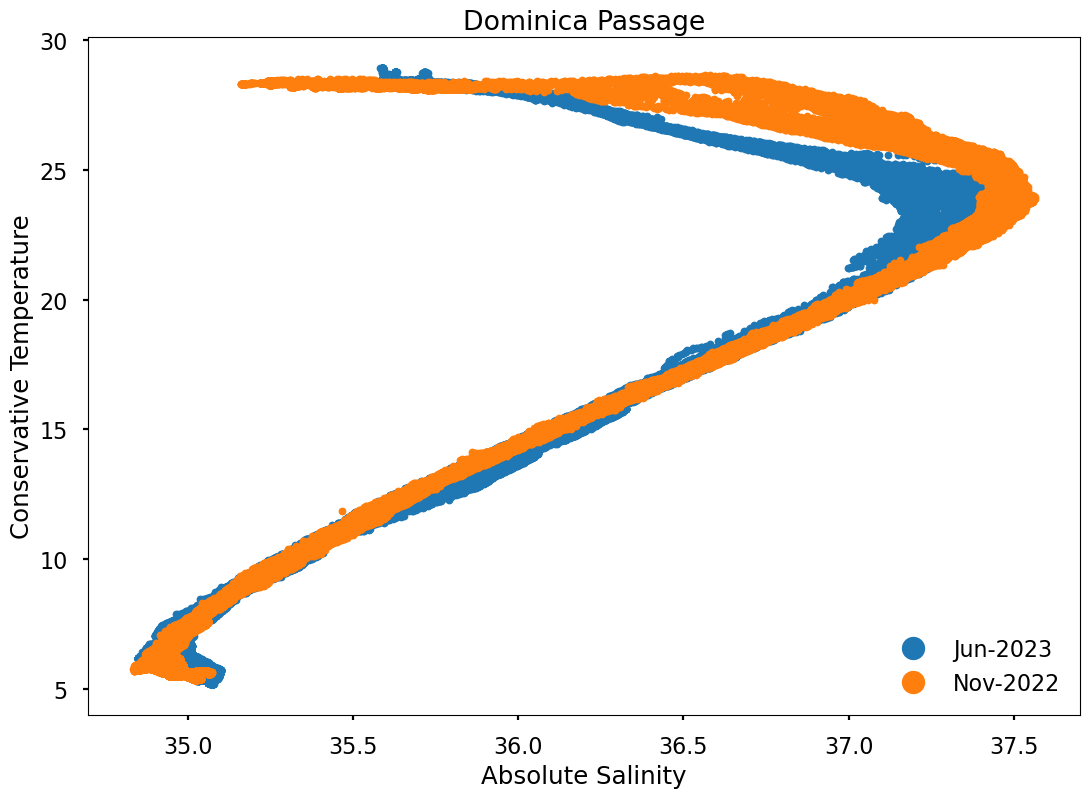

In [14]:
plt.plot(dom23.absolute_salinity,dom23.conservative_temperature,'.',label='Jun-2023')

plt.plot(dom22.absolute_salinity,dom22.conservative_temperature,'.',label='Nov-2022')
plt.legend(loc='lower right',frameon=False,markerscale=3)
plt.title('Dominica Passage')
plt.ylabel('Conservative Temperature')
plt.xlabel('Absolute Salinity')

### St. Lucia Passage

In [6]:
min_lat = 14.10
max_lat = 14.45

stl22 = gdf22[(gdf22.latitude>=min_lat) & (gdf22.latitude<=max_lat)]
stl23 = gdf23[(gdf23.latitude>=min_lat) & (gdf23.latitude<=max_lat)]

Text(0.5, 0, 'Absolute Salinity')

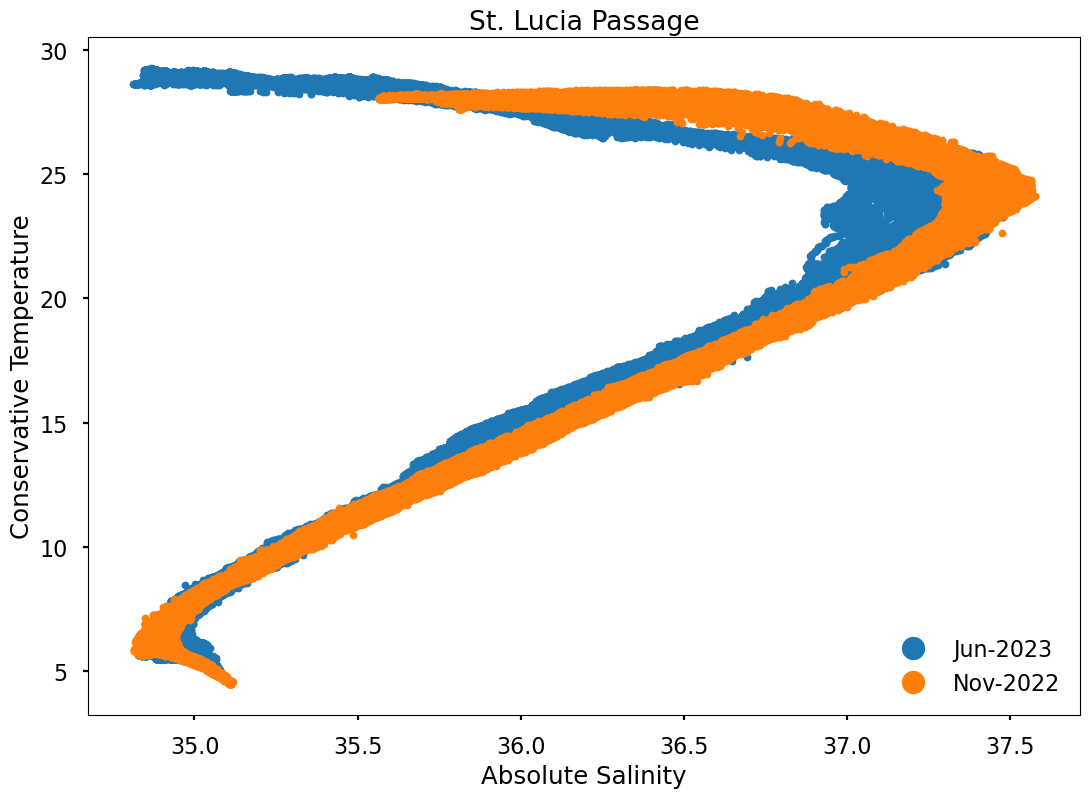

In [15]:
plt.plot(stl23.absolute_salinity,stl23.conservative_temperature,'.',label='Jun-2023')
plt.plot(stl22.absolute_salinity,stl22.conservative_temperature,'.',label='Nov-2022')
plt.legend(loc='lower right',frameon=False,markerscale=3)
plt.title('St. Lucia Passage')
plt.ylabel('Conservative Temperature')
plt.xlabel('Absolute Salinity')

### St. Vincent Passage

In [8]:
min_lat = 13.375
max_lat = 13.725

stv22 = gdf22[(gdf22.latitude>=min_lat) & (gdf22.latitude<=max_lat)]
stv23 = gdf23[(gdf23.latitude>=min_lat) & (gdf23.latitude<=max_lat)]

Text(0.5, 0, 'Absolute Salinity')

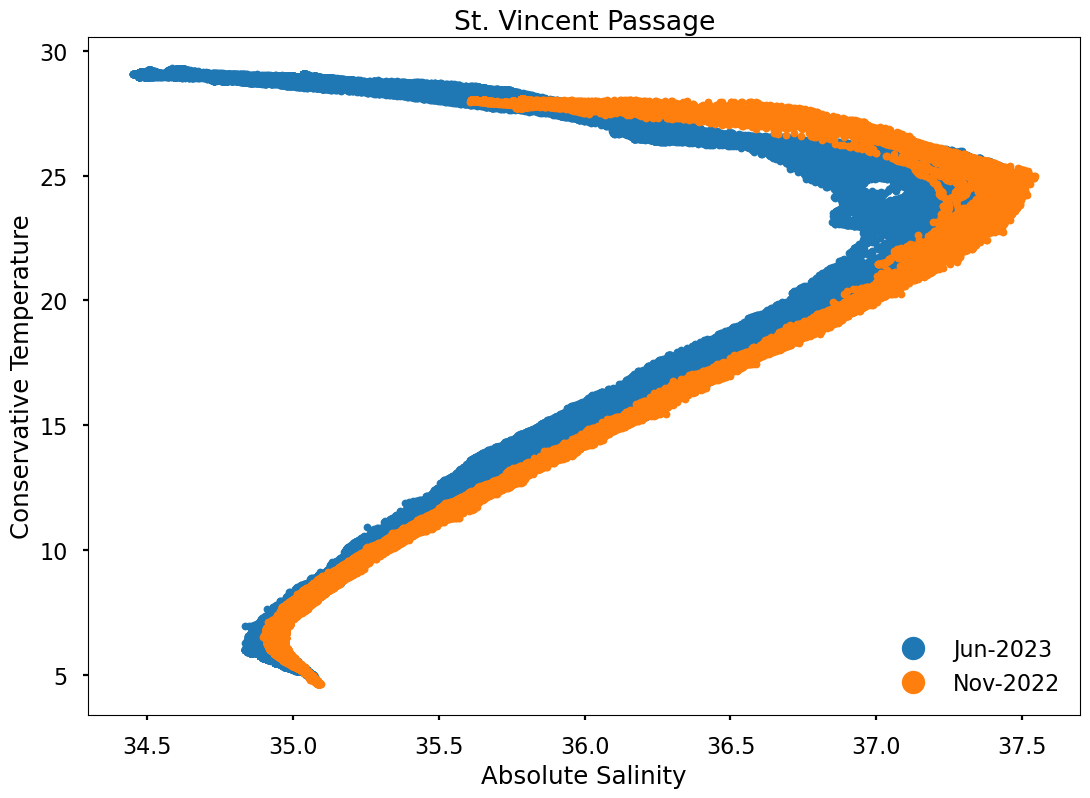

In [16]:
plt.plot(stv23.absolute_salinity,stv23.conservative_temperature,'.',label='Jun-2023')

plt.plot(stv22.absolute_salinity,stv22.conservative_temperature,'.',label='Nov-2022')
plt.legend(loc='lower right',frameon=False,markerscale=3)
plt.title('St. Vincent Passage')
plt.ylabel('Conservative Temperature')
plt.xlabel('Absolute Salinity')

## Plot together

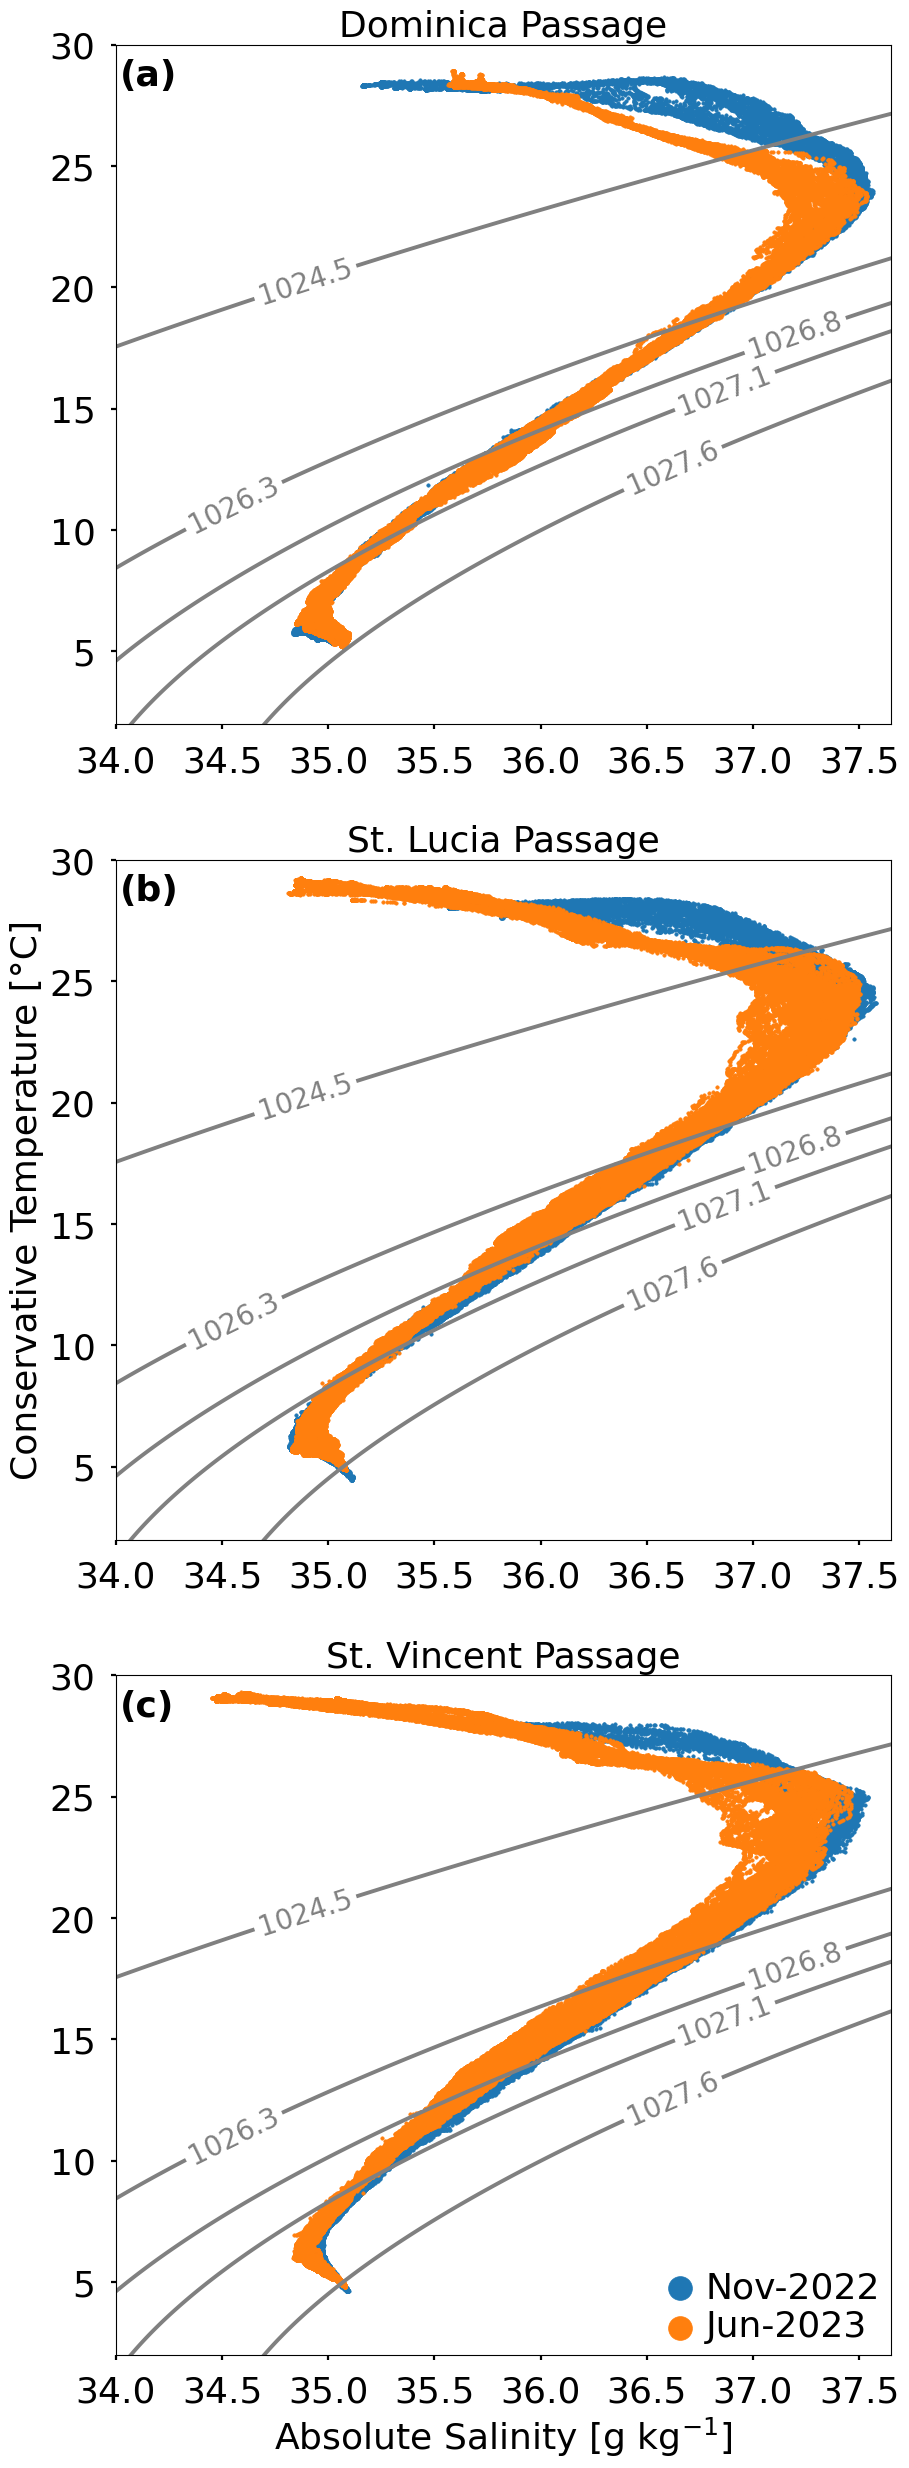

In [10]:
######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
n =499
tempL=np.linspace(mint-1,maxt+1,n)
salL=np.linspace(mins-1,maxs+1,n)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,n)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),n)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
manual_locations = [(34.9, 20), (34.5, 12), (37.2,18), (36.9,15), (36.65,12)]



fig, axs = plt.subplots(3, 1, figsize=(10, 30))

font_size = 26
s=6

## Dominica
axs[0].scatter(dom22.absolute_salinity,dom22.conservative_temperature,s=s)
axs[0].scatter(dom23.absolute_salinity,dom23.conservative_temperature,s=s)

axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].set_title('Dominica Passage',fontsize=font_size)
axs[0].set_ylim(2,30)
axs[0].set_xlim(34,37.65)
axs[0].set_xticks([34,34.5,35,35.5,36,36.5,37,37.5])

## Contours
cs = axs[0].contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
axs[0].clabel(cs,levels, fontsize=20,inline=True,fmt='%.1f', manual=manual_locations)
axs[0].text(0.005,0.94,'(a)', transform=axs[0].transAxes, size=font_size, weight='bold')



## St. Lucia
axs[1].scatter(stl22.absolute_salinity,stl22.conservative_temperature,s=s)
axs[1].scatter(stl23.absolute_salinity,stl23.conservative_temperature,s=s)

axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].set_title('St. Lucia Passage',fontsize=font_size)
axs[1].set_ylabel('Conservative Temperature [°C]',fontsize=font_size)
axs[1].set_ylim(2,30)
axs[1].set_xlim(34,37.65)
axs[1].set_xticks([34,34.5,35,35.5,36,36.5,37,37.5])

## Contours
cs = axs[1].contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
axs[1].clabel(cs,levels, fontsize=20,inline=True,fmt='%.1f', manual=manual_locations)

axs[1].text(0.005,0.94,'(b)', transform=axs[1].transAxes, size=font_size, weight='bold')




## St. Vincent
axs[2].scatter(stv22.absolute_salinity,stv22.conservative_temperature,s=s,label='Nov-2022')
axs[2].scatter(stv23.absolute_salinity,stv23.conservative_temperature,s=s,label='Jun-2023')

axs[2].tick_params(axis='both', which='major', labelsize=font_size)
axs[2].set_title('St. Vincent Passage',fontsize=font_size)
axs[2].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize=font_size)
axs[2].set_ylim(2,30)
axs[2].set_xlim(34,37.65)
axs[2].set_xticks([34,34.5,35,35.5,36,36.5,37,37.5])

## Contours
cs = axs[2].contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
axs[2].clabel(cs,levels, fontsize=20,inline=True,fmt='%.1f', manual=manual_locations)


axs[2].text(0.005,0.94,'(c)', transform=axs[2].transAxes, size=font_size, weight='bold')
axs[2].legend(fontsize=font_size,markerscale=7,frameon=False,loc='lower right',handletextpad=-0.3, labelspacing=0.15,borderaxespad=-0.1)


plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/Plots/Passages_T_S_2022_2023.png', bbox_inches='tight',dpi=300,facecolor='white')



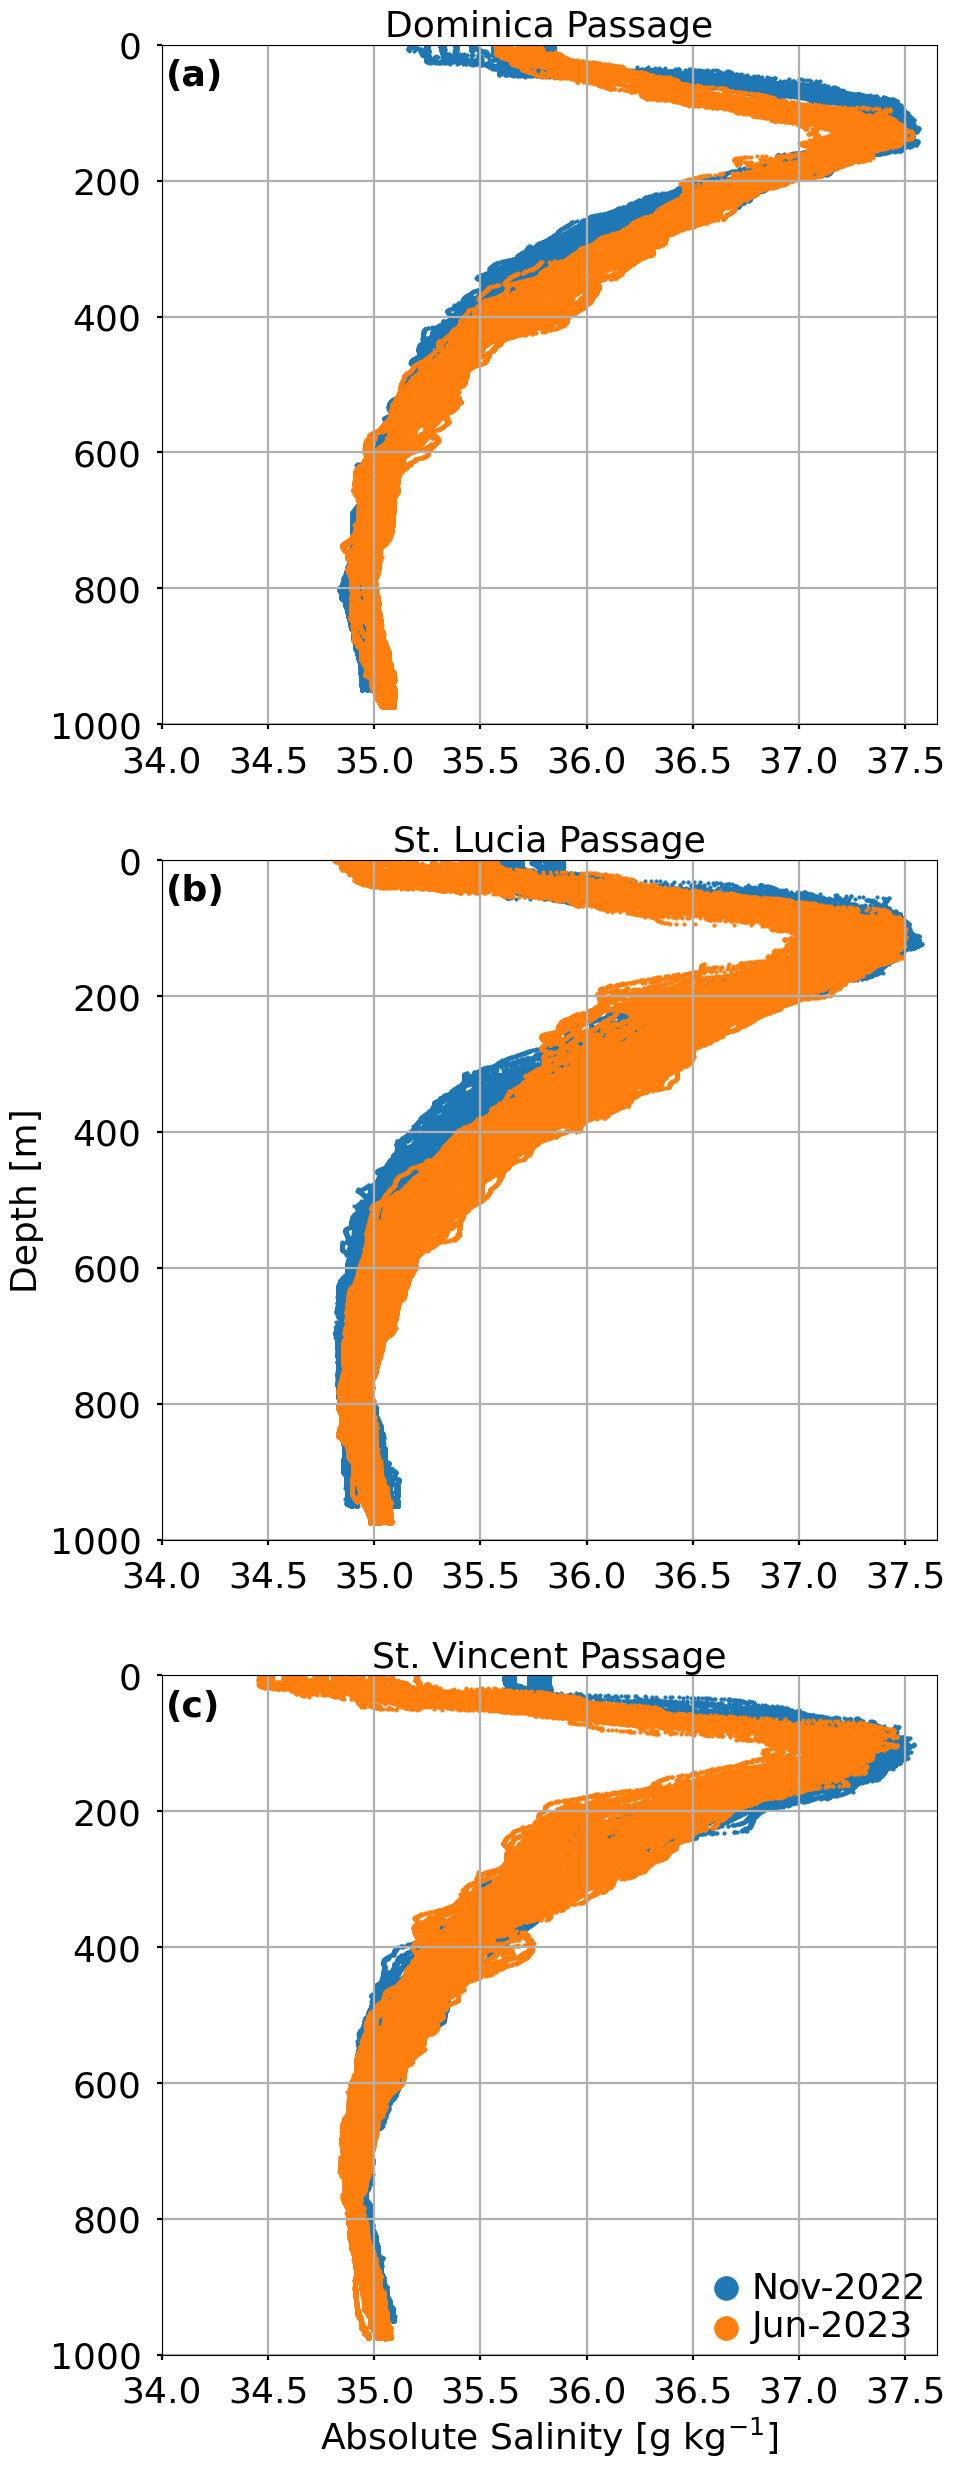

In [11]:

fig, axs = plt.subplots(3, 1, figsize=(10, 30))

font_size = 26
s=6

## Dominica
axs[0].scatter(dom22.absolute_salinity,dom22.depth,s=s)
axs[0].scatter(dom23.absolute_salinity,dom23.depth,s=s)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].set_title('Dominica Passage',fontsize=font_size)
axs[0].set_ylim(1000,0)
axs[0].set_xlim(34,37.65)
axs[0].set_xticks([34,34.5,35,35.5,36,36.5,37,37.5])
axs[0].grid()
axs[0].text(0.005,0.94,'(a)', transform=axs[0].transAxes, size=font_size, weight='bold')

## St. Lucia
axs[1].scatter(stl22.absolute_salinity,stl22.depth,s=s)
axs[1].scatter(stl23.absolute_salinity,stl23.depth,s=s)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].set_title('St. Lucia Passage',fontsize=font_size)
axs[1].set_ylim(1000,0)
axs[1].set_xlim(34,37.65)
axs[1].set_xticks([34,34.5,35,35.5,36,36.5,37,37.5])
axs[1].set_ylabel('Depth [m]',fontsize=font_size)
axs[1].grid()
axs[1].text(0.005,0.94,'(b)', transform=axs[1].transAxes, size=font_size, weight='bold')


## St. Vincent
axs[2].scatter(stv22.absolute_salinity,stv22.depth,s=s,label='Nov-2022')
axs[2].scatter(stv23.absolute_salinity,stv23.depth,s=s,label='Jun-2023')
axs[2].tick_params(axis='both', which='major', labelsize=font_size)
axs[2].set_title('St. Vincent Passage',fontsize=font_size)
axs[2].set_ylim(1000,0)
axs[2].set_xlim(34,37.65)
axs[2].set_xticks([34,34.5,35,35.5,36,36.5,37,37.5])
axs[2].set_xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize=font_size)
axs[2].grid()
axs[2].text(0.005,0.94,'(c)', transform=axs[2].transAxes, size=font_size, weight='bold')
axs[2].legend(fontsize=font_size,markerscale=7,frameon=False,loc='lower right',handletextpad=-0.3, labelspacing=0.15,borderaxespad=-0.1)


plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/Plots/Passages_S_Profile_2022_2023.png', bbox_inches='tight',dpi=300,facecolor='white')


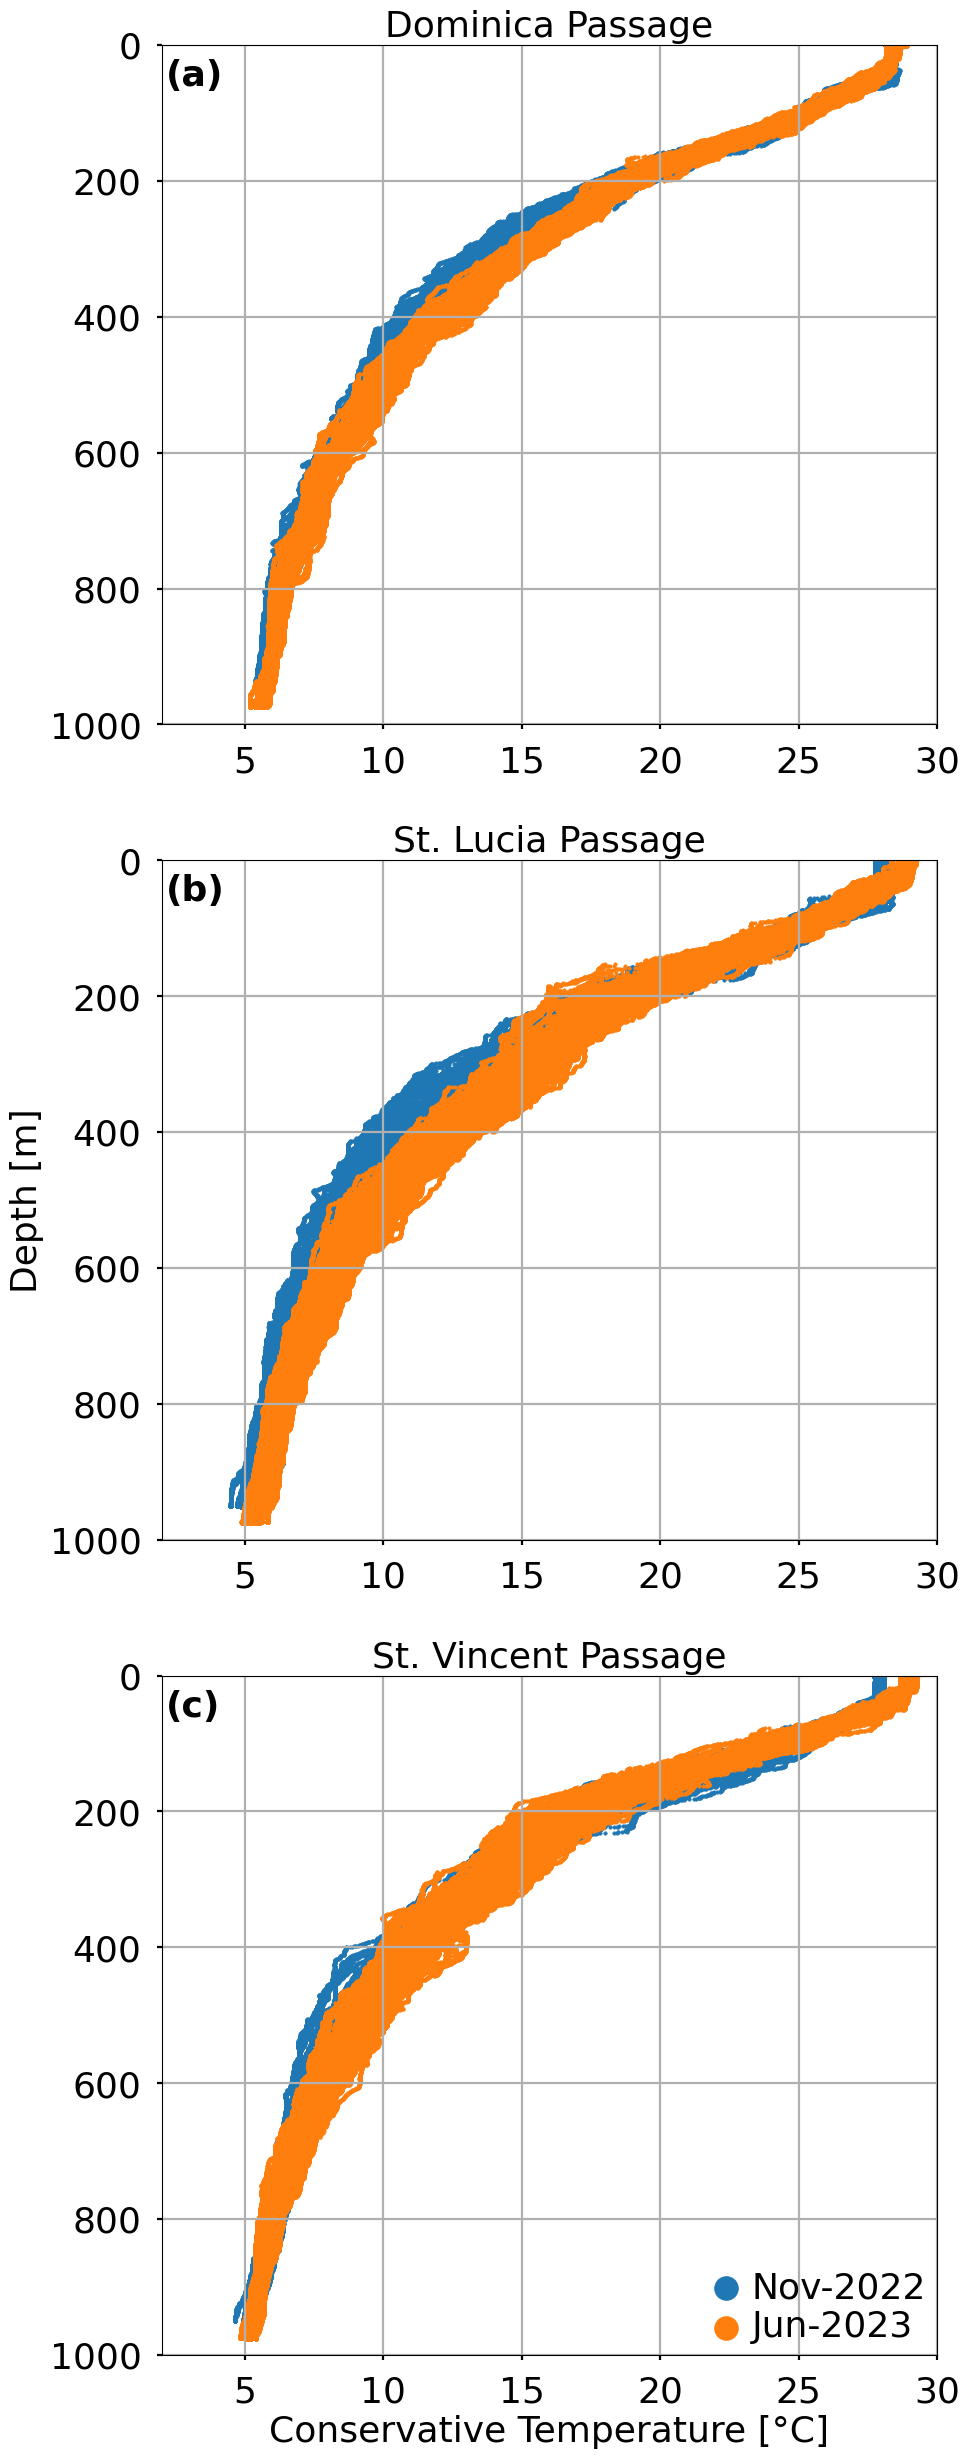

In [12]:

fig, axs = plt.subplots(3, 1, figsize=(10, 30))

font_size = 26
s=6

## Dominica
axs[0].scatter(dom22.conservative_temperature,dom22.depth,s=s)
axs[0].scatter(dom23.conservative_temperature,dom23.depth,s=s)
axs[0].tick_params(axis='both', which='major', labelsize=font_size)
axs[0].set_title('Dominica Passage',fontsize=font_size)
axs[0].set_ylim(1000,0)
axs[0].set_xlim(2,30)
axs[0].grid()
axs[0].text(0.005,0.94,'(a)', transform=axs[0].transAxes, size=font_size, weight='bold')

## St. Lucia
axs[1].scatter(stl22.conservative_temperature,stl22.depth,s=s)
axs[1].scatter(stl23.conservative_temperature,stl23.depth,s=s)
axs[1].tick_params(axis='both', which='major', labelsize=font_size)
axs[1].set_title('St. Lucia Passage',fontsize=font_size)
axs[1].set_ylim(1000,0)
axs[1].set_xlim(2,30)
axs[1].set_ylabel('Depth [m]',fontsize=font_size)
axs[1].grid()
axs[1].text(0.005,0.94,'(b)', transform=axs[1].transAxes, size=font_size, weight='bold')


## St. Vincent
axs[2].scatter(stv22.conservative_temperature,stv22.depth,s=s,label='Nov-2022')
axs[2].scatter(stv23.conservative_temperature,stv23.depth,s=s,label='Jun-2023')
axs[2].tick_params(axis='both', which='major', labelsize=font_size)
axs[2].set_title('St. Vincent Passage',fontsize=font_size)
axs[2].set_ylim(1000,0)
axs[2].set_xlim(2,30)
axs[2].set_xlabel('Conservative Temperature [°C]',fontsize=font_size)
axs[2].grid()
axs[2].text(0.005,0.94,'(c)', transform=axs[2].transAxes, size=font_size, weight='bold')
axs[2].legend(fontsize=font_size,markerscale=7,frameon=False,loc='lower right',handletextpad=-0.3, labelspacing=0.15,borderaxespad=-0.1)


plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/Plots/Passages_T_Profile_2022_2023.png', bbox_inches='tight',dpi=300,facecolor='white')



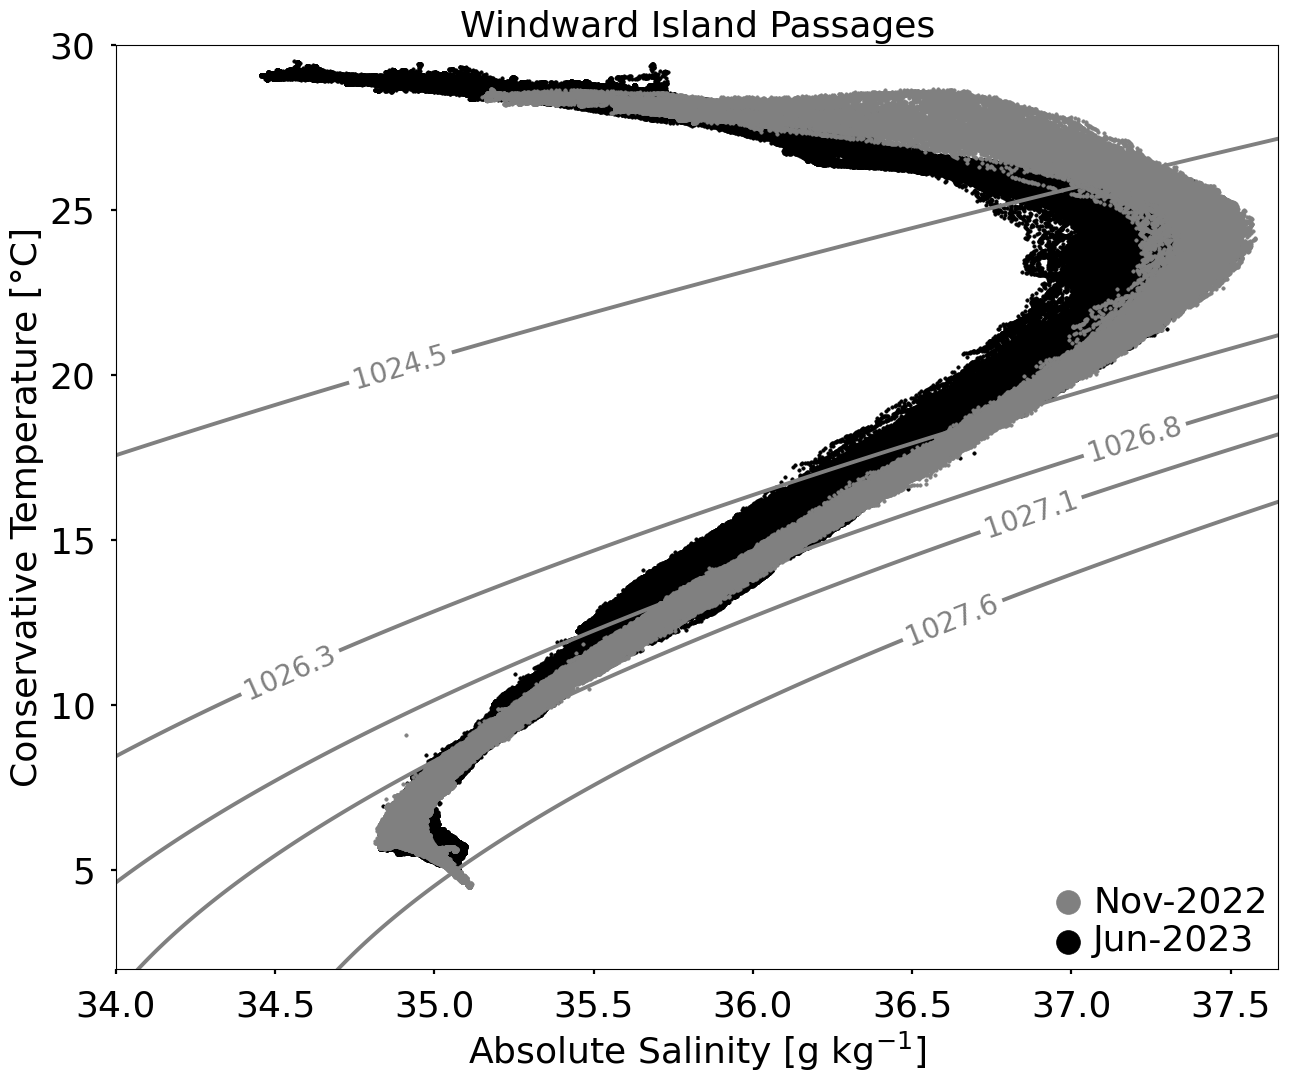

In [17]:
######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
n =499
tempL=np.linspace(mint-1,maxt+1,n)
salL=np.linspace(mins-1,maxs+1,n)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,n)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),n)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
manual_locations = [(34.9, 20), (34.5, 12), (37.2,18), (36.9,15), (36.65,12)]



plt.figure(figsize=(15,12))
font_size = 26
s=6


## Dominica
plt.scatter(gdf23.absolute_salinity,gdf23.conservative_temperature,color='black',label='Jun-2023',s=s)
plt.scatter(gdf22.absolute_salinity,gdf22.conservative_temperature,color='grey',label='Nov-2022',s=s)

plt.title('Windward Island Passages',fontsize=font_size)

plt.gca().tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(2,30)
plt.xlim(34,37.65)
plt.xlabel('Absolute Salinity [g kg$^{-1}$]',fontsize=font_size)
plt.ylabel('Conservative Temperature [°C]',fontsize=font_size)
plt.gca().set_xticks([34,34.5,35,35.5,36,36.5,37,37.5])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels),fontsize=font_size,markerscale=7,frameon=False,loc='lower right',handletextpad=-0.3, labelspacing=0.15,borderaxespad=-0.1)

## Contours
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
plt.clabel(cs,levels, fontsize=20,inline=True,fmt='%.1f', manual=manual_locations)

plt.savefig('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Windward_Passages_Glider_Analysis/Plots/All_2022_2023_T_S.png', bbox_inches='tight',dpi=300,facecolor='white')



## Compare with WIMP

In [18]:
temp_ds = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav/1.00/woa18_decav_t00_01.nc', decode_times=False)
sal_ds  = xr.open_dataset('https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/salinity/decav/1.00/woa18_decav_s00_01.nc', decode_times=False)
temp_ds

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 4.326e+03
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_an                (time, depth, lat, lon) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
    t_oa                (time, depth, lat, lon) float32 ...
    t_gp                (time, depth, lat, lon) float64 ...
Attributes: (12/49)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

In [19]:
## Convert temp and sal
p = gsw.p_from_z(-temp_ds.depth,15)

## Absolute salinity
SA = gsw.SA_from_SP(sal_ds.s_an[0,:,105,119], p, -60, 15)
## Conservative temperature
CT = gsw.CT_from_t(SA, temp_ds.t_an[0,:,105,119], p)


In [149]:
## WIMP

ands = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIMP_NC_T_S_U_V/AN.nc')
dods = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIMP_NC_T_S_U_V/DO.nc')
slds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIMP_NC_T_S_U_V/SL.nc')
svds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIMP_NC_T_S_U_V/SV.nc')
grds = xr.open_dataset('/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/WIMP_NC_T_S_U_V/GR.nc')
ands.time

<xarray.DataArray 'time' (time: 8)>
array(['1993-06', '1994-04', '1994-07', '1996-03', '1996-07', '1997-06',
       '2000-04', '2001-04'], dtype=object)
Coordinates:
  * time     (time) object '1993-06' '1994-04' '1994-07' ... '2000-04' '2001-04'

In [209]:
svds.time

<xarray.DataArray 'time' (time: 15)>
array(['1991-12', '1992-05', '1992-09', '1992-12', '1993-03', '1993-06',
       '1994-04', '1994-07', '1995-09', '1996-03', '1996-07', '1997-06',
       '2000-04', '2000-07', '2001-04'], dtype=object)
Coordinates:
  * time     (time) object '1991-12' '1992-05' '1992-09' ... '2000-07' '2001-04'

(34.0, 38.0)

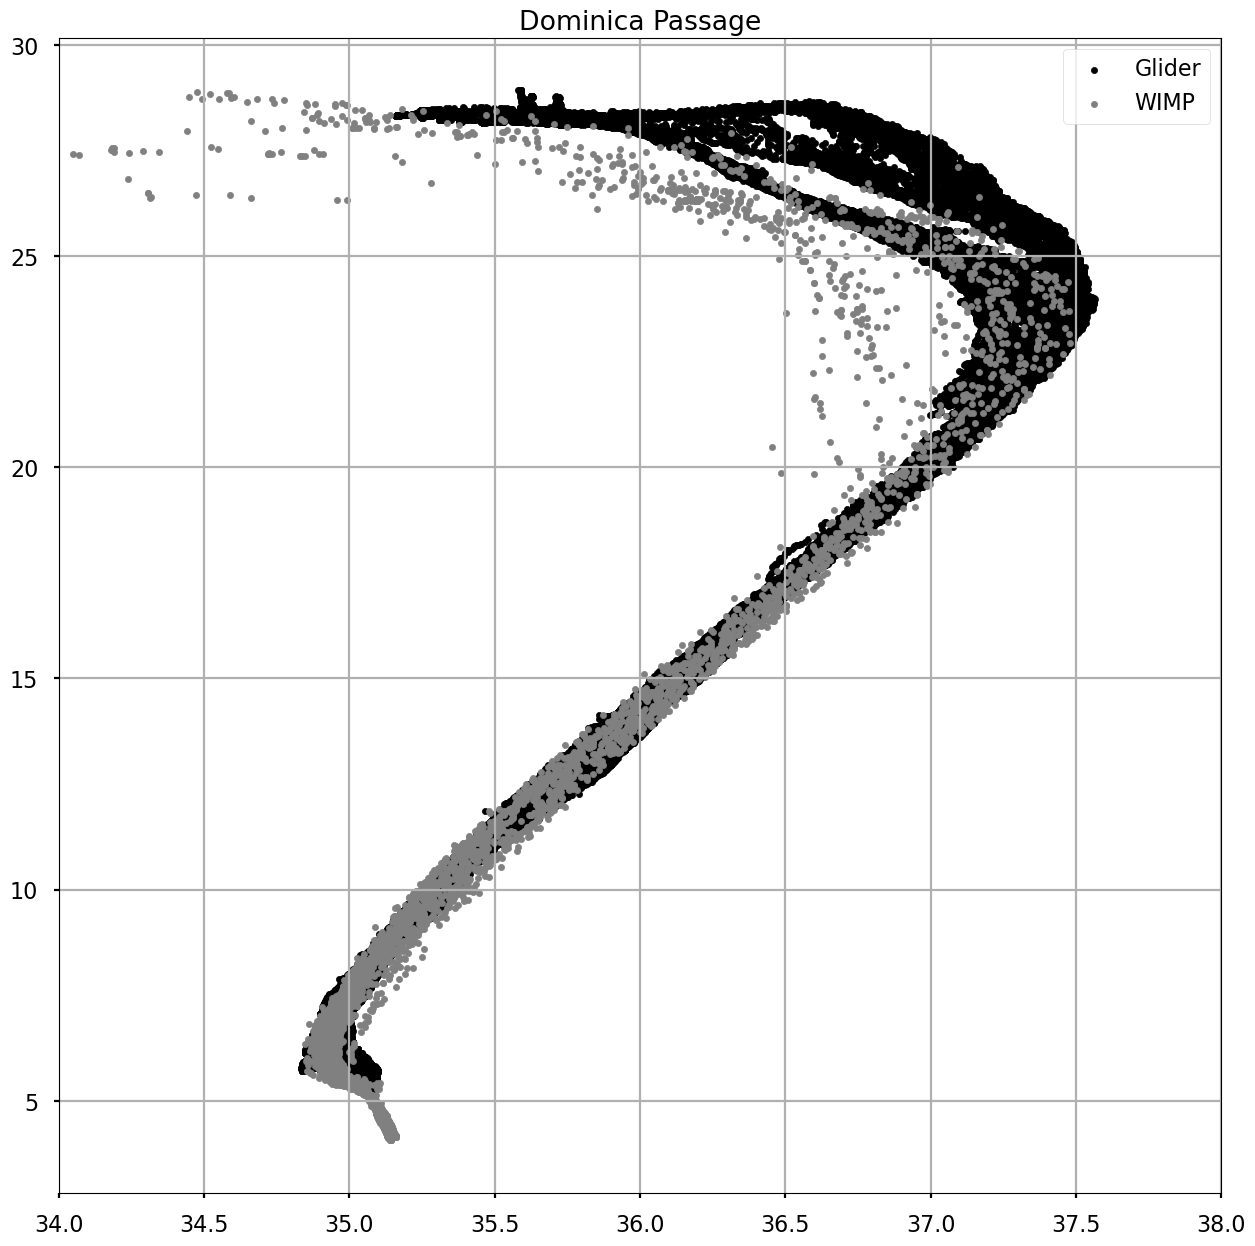

In [32]:
s = 20


plt.figure(figsize=(15,15))
plt.grid()
plt.scatter(dom22.absolute_salinity,dom22.conservative_temperature,color='black',s=s,label='Glider')
plt.scatter(dom23.absolute_salinity,dom23.conservative_temperature,color='black',s=s)

for x in np.arange(0,len(dods.stn_num)):
    for y in np.arange(0,len(dods.time)):
        plt.scatter(dods.salinity[x,y,:],dods.temperature[x,y,:],color='grey',s=s)

plt.scatter(dods.salinity[x,y,:],dods.temperature[x,y,:],color='grey',s=s,label='WIMP')

plt.legend()
plt.title('Dominica Passage')
plt.xlim(34,38)

(34.0, 38.0)

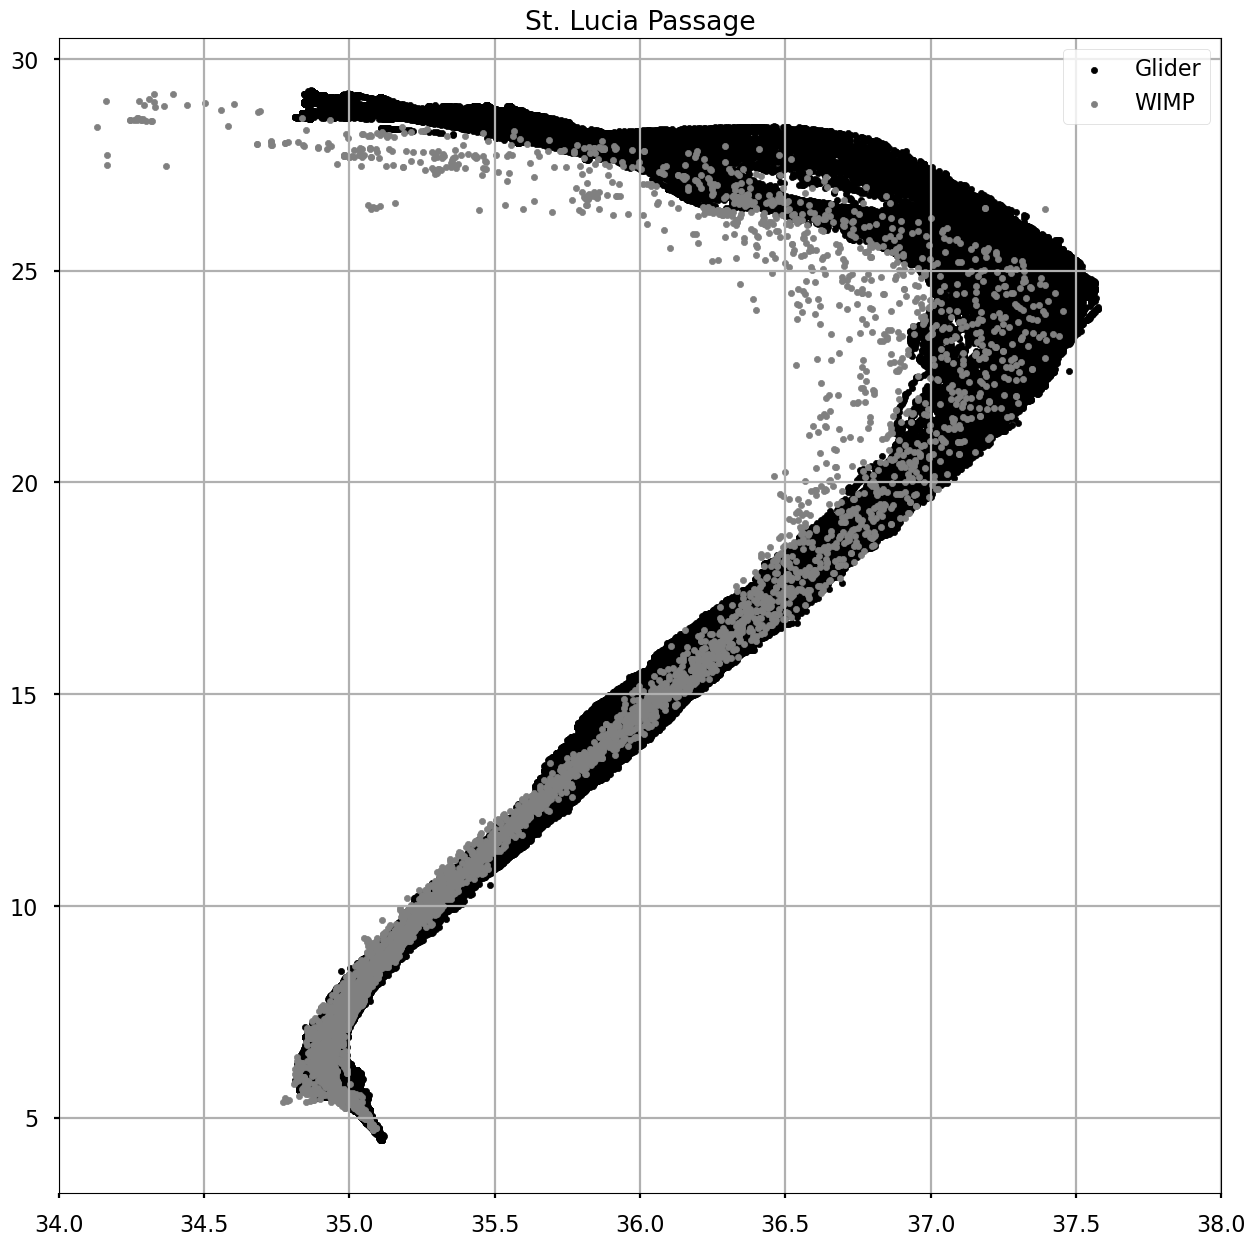

In [34]:
s = 20


plt.figure(figsize=(15,15))
plt.grid()
plt.scatter(stl22.absolute_salinity,stl22.conservative_temperature,color='black',s=s,label='Glider')
plt.scatter(stl23.absolute_salinity,stl23.conservative_temperature,color='black',s=s)

for x in np.arange(0,len(slds.stn_num)):
    for y in np.arange(0,len(slds.time)):
        plt.scatter(slds.salinity[x,y,:],slds.temperature[x,y,:],color='grey',s=s)

plt.scatter(slds.salinity[x,y,:],slds.temperature[x,y,:],color='grey',s=s,label='WIMP')

plt.legend()
plt.title('St. Lucia Passage')
plt.xlim(34,38)


(34.0, 38.0)

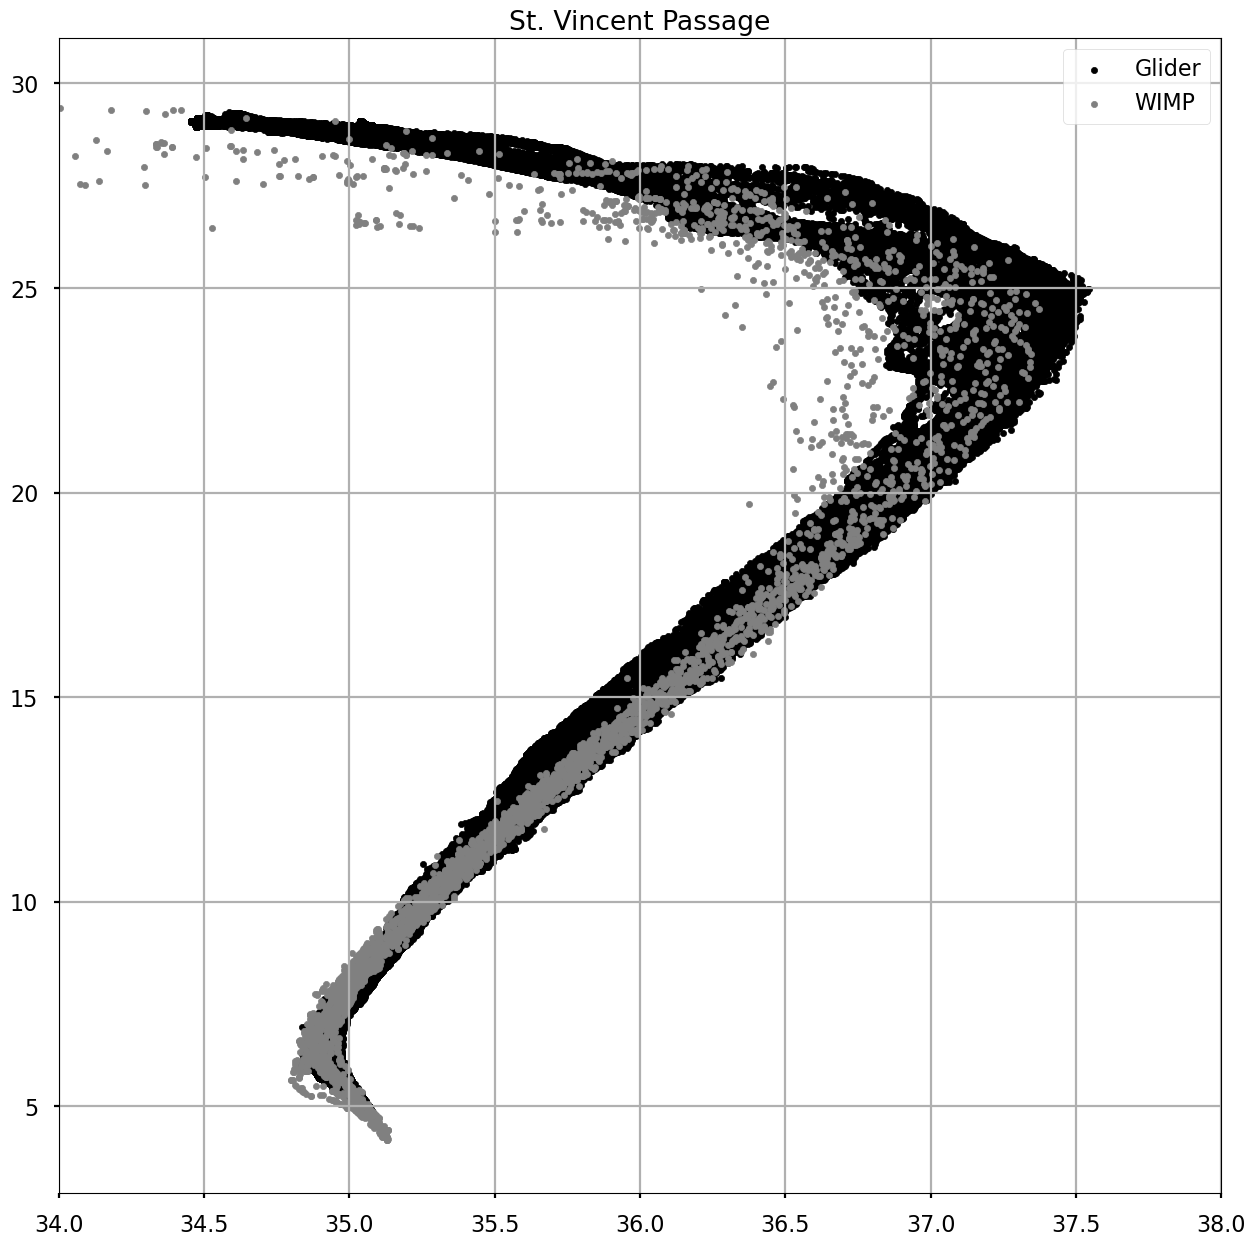

In [36]:
s = 20


plt.figure(figsize=(15,15))
plt.grid()
plt.scatter(stv22.absolute_salinity,stv22.conservative_temperature,color='black',s=s,label='Glider')
plt.scatter(stv23.absolute_salinity,stv23.conservative_temperature,color='black',s=s)

for x in np.arange(0,len(svds.stn_num)):
    for y in np.arange(0,len(svds.time)):
        plt.scatter(svds.salinity[x,y,:],svds.temperature[x,y,:],color='grey',s=s)

plt.scatter(svds.salinity[x,y,:],svds.temperature[x,y,:],color='grey',s=s,label='WIMP')

plt.legend()
plt.title('St. Vincent Passage')
plt.xlim(34,38)


(1000.0, 0.0)

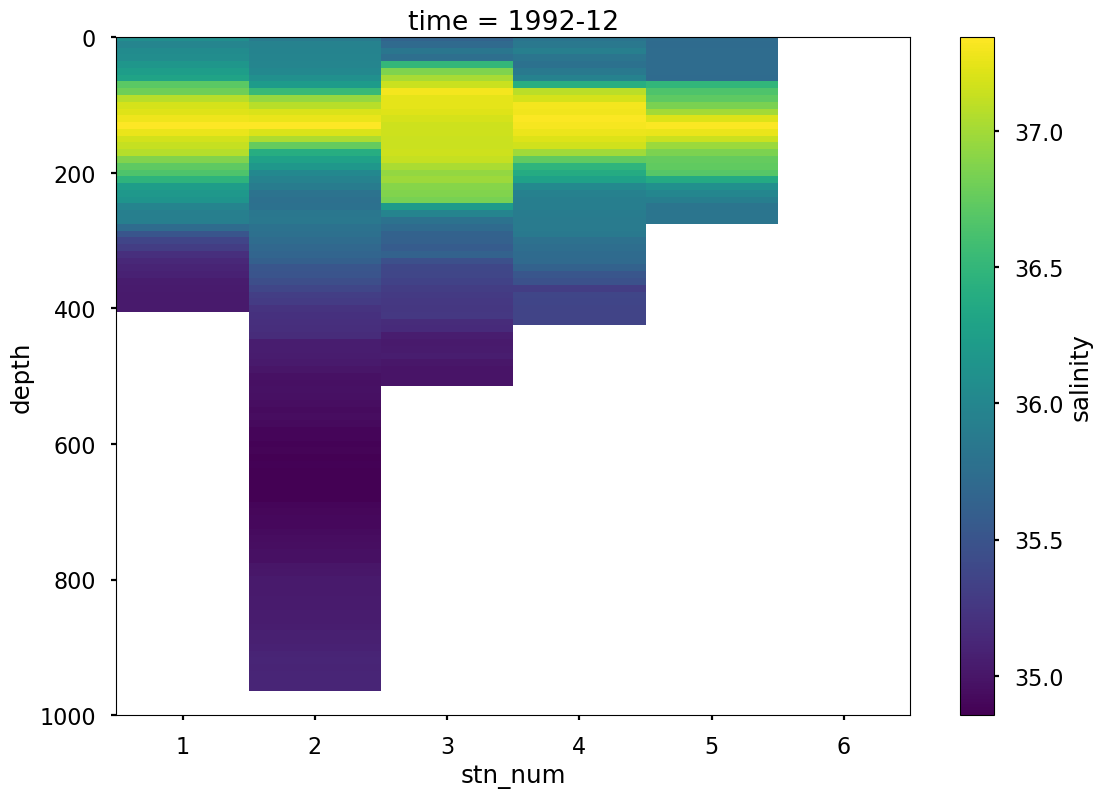

In [46]:
svds.salinity[:,3,:].transpose().plot()
plt.ylim(1000,0)

## Load some Anegada Passage data

In [159]:
ds_id = 'ru29-20200908T1623-profile-sci-delayed'

## Load flight data
variables = ['depth','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity','source_file']
ru29_2020 = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
ru29_2020.columns = variables

## Great way to find start and end times!!
start_times = ru29_2020.groupby('source_file').first().time.values
end_times   = ru29_2020.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(ru29_2020.salinity.values, ru29_2020.pressure.values, ru29_2020.longitude.values, ru29_2020.latitude.values)
ru29_2020['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, ru29_2020.potential_temperature.values, ru29_2020.pressure.values)
ru29_2020['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
ru29_2020['sigma0'] = sigma0


In [160]:
ds_id = 'ru29-20210908T1943-profile-sci-delayed'

## Load flight data
variables = ['depth','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity','source_file']
ru29_2021a = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
ru29_2021a.columns = variables

## Great way to find start and end times!!
start_times = ru29_2021a.groupby('source_file').first().time.values
end_times   = ru29_2021a.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(ru29_2021a.salinity.values, ru29_2021a.pressure.values, ru29_2021a.longitude.values, ru29_2021a.latitude.values)
ru29_2021a['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, ru29_2021a.potential_temperature.values, ru29_2021a.pressure.values)
ru29_2021a['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
ru29_2021a['sigma0'] = sigma0



In [161]:
ds_id = 'ru29-20210630T1343-profile-sci-delayed'

## Load flight data
variables = ['depth','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity','source_file']
ru29_2021b = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
ru29_2021b.columns = variables

## Great way to find start and end times!!
start_times = ru29_2021b.groupby('source_file').first().time.values
end_times   = ru29_2021b.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(ru29_2021b.salinity.values, ru29_2021b.pressure.values, ru29_2021b.longitude.values, ru29_2021b.latitude.values)
ru29_2021b['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, ru29_2021b.potential_temperature.values, ru29_2021b.pressure.values)
ru29_2021b['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
ru29_2021b['sigma0'] = sigma0



In [166]:
ds_id = 'ru36-20220223T1807-profile-sci-delayed'

## Load flight data
variables = ['depth','pressure','latitude', 'longitude', 'time', 'potential_temperature', 'salinity','source_file','oxygen_concentration_shifted']
ru29_2022 = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
ru29_2022.columns = variables

## Great way to find start and end times!!
start_times = ru29_2022.groupby('source_file').first().time.values
end_times   = ru29_2022.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

########## Convert variables for calculations
## Absolute salinity
SA = gsw.SA_from_SP(ru29_2022.salinity.values, ru29_2022.pressure.values, ru29_2022.longitude.values, ru29_2022.latitude.values)
ru29_2022['absolute_salinity'] = SA
## Conservative temperature
CT = gsw.CT_from_t(SA, ru29_2022.potential_temperature.values, ru29_2022.pressure.values)
ru29_2022['conservative_temperature'] = CT
## Potential density
sigma0  = gsw.sigma0(SA,CT)+1000
ru29_2022['sigma0'] = sigma0



Text(0.5, 1.0, 'Anegada Passage')

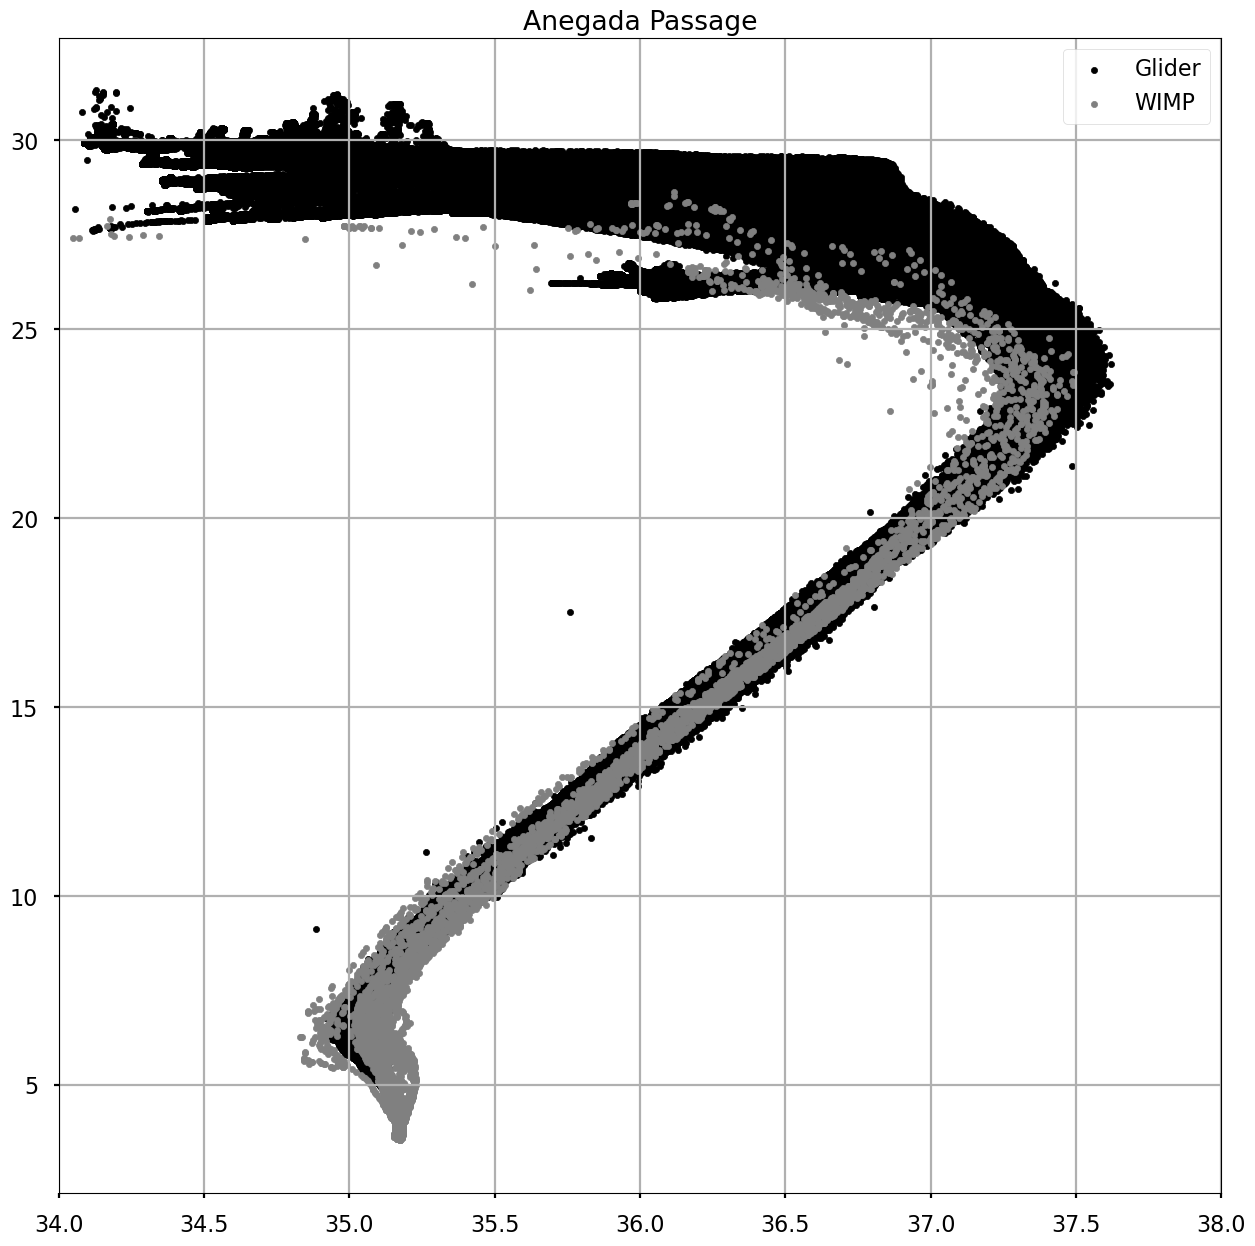

In [184]:
s = 20
lwd = 2

plt.figure(figsize=(15,15))
plt.grid()

plt.scatter(ru29_2020.absolute_salinity,ru29_2020.conservative_temperature,color='black',s=s,label='Glider')
plt.scatter(ru29_2021a.absolute_salinity,ru29_2021a.conservative_temperature,color='black',s=s)
plt.scatter(ru29_2021b.absolute_salinity,ru29_2021b.conservative_temperature,color='black',s=s)
plt.scatter(ru29_2022.absolute_salinity,ru29_2022.conservative_temperature,color='black',s=s)

for x in np.arange(0,len(ands.stn_num)):
    for y in np.arange(0,len(ands.time)):
        plt.scatter(ands.salinity[x,y,:],ands.temperature[x,y,:],color='grey',s=s)

plt.scatter(ands.salinity[x,y,:],ands.temperature[x,y,:],color='grey',s=s,label='WIMP')

plt.xlim(34,38)
plt.legend()
plt.title('Anegada Passage')

## Compare with Argo

In [51]:
lon_min = -75
lon_max = -60
lat_min = 10
lat_max = 15


argo = get_argo_floats_by_time(bbox=(lon_min, lon_max, lat_min, lat_max),
                               time_start=dt.date(1980,1,1),
                               time_end=dt.date.today())

argo = argo.reset_index()

argo

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.10/site-packages/erddapy/core/interfaces.py:33: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data, **(pandas_kwargs or {}))


argo                time        lon        lat  pres (decibar)  \
0         49060 2001-09-19 09:06:09 -60.081000  12.107000            10.0   
1         49060 2001-09-19 09:06:09 -60.081000  12.107000            20.0   
2         49060 2001-09-19 09:06:09 -60.081000  12.107000            30.0   
3         49060 2001-09-19 09:06:09 -60.081000  12.107000            40.0   
4         49060 2001-09-19 09:06:09 -60.081000  12.107000            50.0   
...         ...                 ...        ...        ...             ...   
673195  6902966 2020-10-16 07:58:00 -60.892362  11.578677           663.5   
673196  6902966 2020-10-16 07:58:00 -60.892362  11.578677           665.2   
673197  6902966 2020-10-16 07:58:00 -60.892362  11.578677           667.0   
673198  6902966 2020-10-16 07:58:00 -60.892362  11.578677           671.1   
673199  6902966 2020-10-16 07:58:00 -60.892362  11.578677           672.4   

        temp_adjusted (degree_Celsius)  psal_adjusted (PSU) temp_adjusted_qc  \
0                               29.104             34.32093                1   
1                               29.096             34.33333                1   
2                               28.296             36.00624                1   
3                               27.864             36.08112                1   
4                               27.584             36.12217                1   
...                                ...                  ...              ...   
673195                           7.530             34.80000                1   
673196                           7.408             34.80900                1   
673197                           7.166             34.79000                1   
673198                           7.060             34.76300                1   
673199                           6.684             34.73600                1   

       psal_adjusted_qc  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  
...                 ...  
673195                1  
673196                1  
673197                1  
673198                1  
673199                1  

[673200 rows x 9 columns]

## Convert Argo Temperature and Salinity and QAQC

In [81]:
argo['absolute_salinity'] = gsw.SA_from_SP(argo['psal_adjusted (PSU)'], -argo['pres (decibar)'], argo['lon'], argo['lat'])
argo['conservative_temperature'] = gsw.CT_from_t(argo['absolute_salinity'], argo['temp_adjusted (degree_Celsius)'], -argo['pres (decibar)'])
argo['depth'] = gsw.z_from_p(-argo['pres (decibar)'].values,argo['lat'].values)
argo['absolute_salinity'][argo['absolute_salinity'] > 40] = np.nan
argo['absolute_salinity'][argo['absolute_salinity'] < 30] = np.nan

argo['absolute_salinity'][argo['psal_adjusted_qc']!=1] = np.nan
argo['conservative_temperature'][argo['temp_adjusted_qc']!=1] = np.nan

## Now remove all rows with nan data
argo = argo.dropna(axis=0)

## Potential density
argo['sigma0']  = gsw.sigma0(argo['absolute_salinity'],argo['conservative_temperature'] )+1000


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80836/2164042503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  argo['absolute_salinity'] = gsw.SA_from_SP(argo['psal_adjusted (PSU)'], -argo['pres (decibar)'], argo['lon'], argo['lat'])
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_80836/2164042503.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  argo['conservative_temperature'] = gsw.CT_from_t(argo['absolute_salinity'], argo['temp_adjusted (degree_Celsius)'], -argo['pres (deci

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


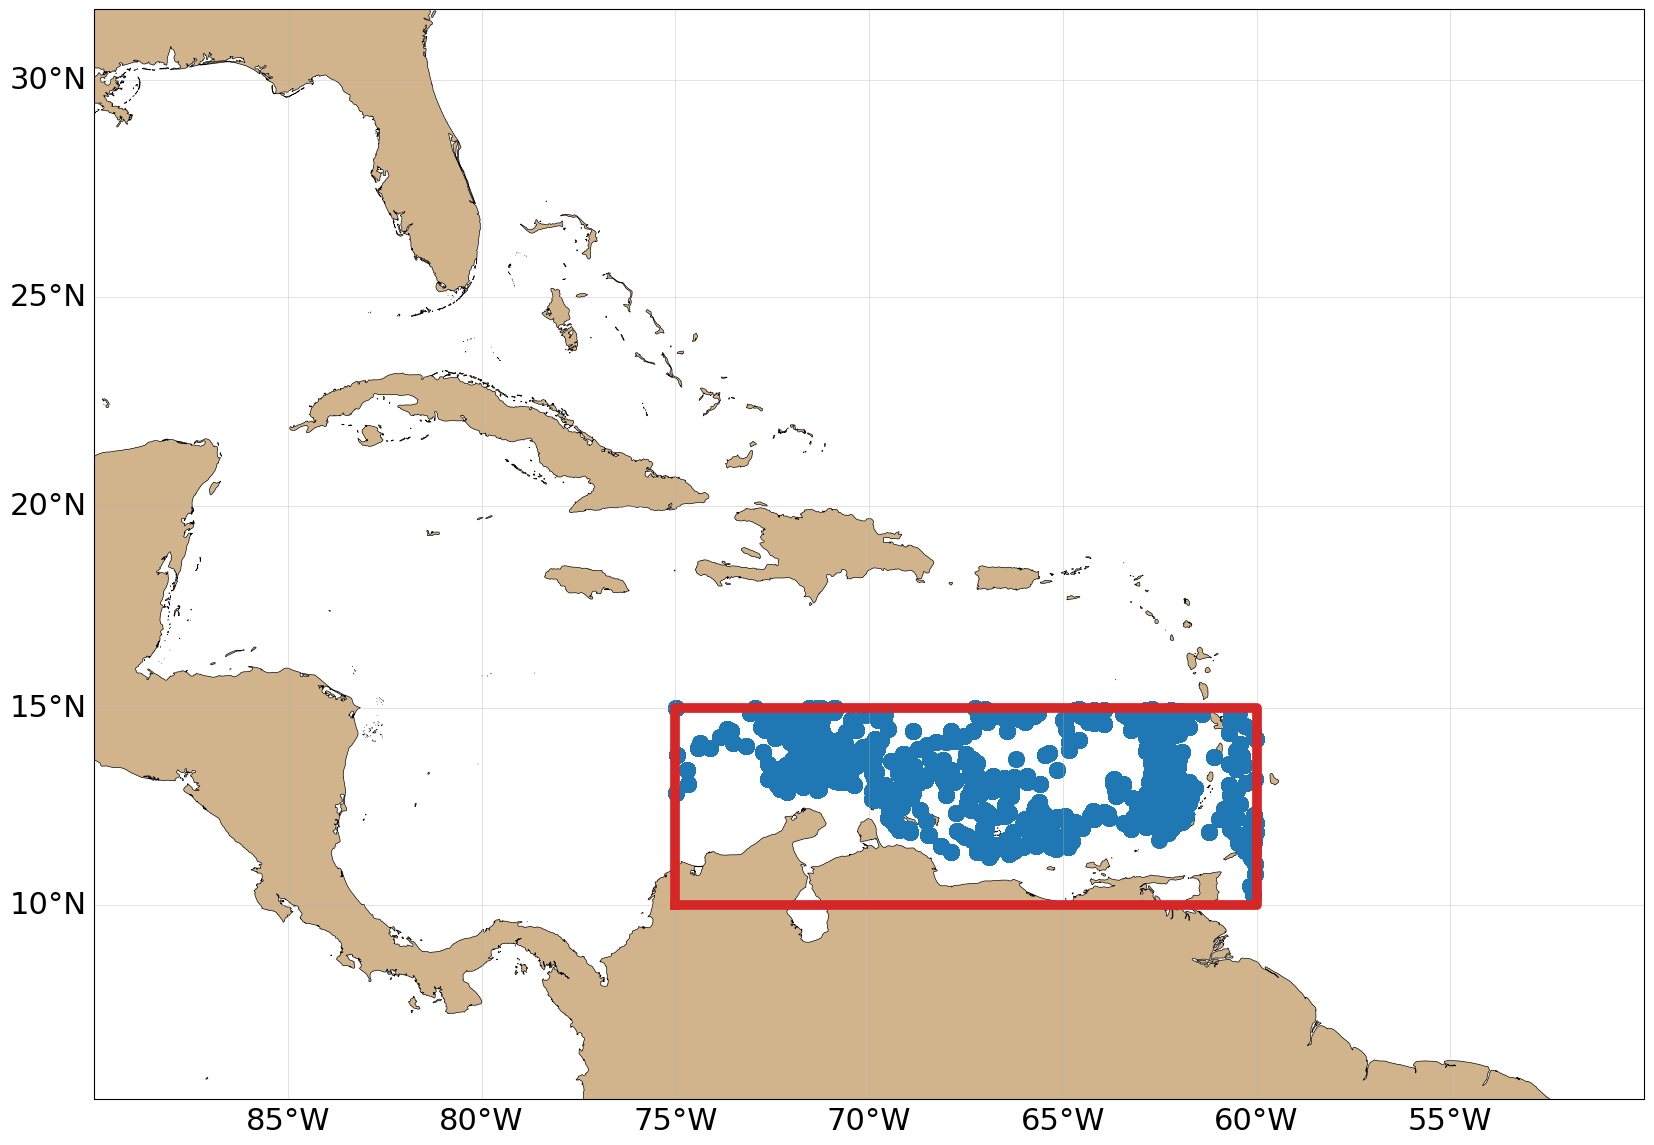

In [82]:
fig, ax = plt.subplots(figsize=(20, 15), subplot_kw=dict(projection=ccrs.Mercator()))

## Set lon and lat ranges
lon1 = -90
lon2 = -50
lat1 = 5
lat2 = 30

ax.set_extent([lon1, lon2, lat1, lat2])


LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor='tan'
)

ax.add_feature(LAND, zorder=0)

glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False
glb.xlabel_style = {'size': 22}
glb.ylabel_style = {'size': 22}


## Box around actual figure region
ax.plot([lon_min, lon_min,  lon_max, lon_max, lon_min] , 
                        [lat_min, lat_max, lat_max, lat_min, lat_min ], color='tab:red',linewidth=7,  transform=ccrs.PlateCarree(), zorder=100 )

plt.scatter(argo.lon.values,argo.lat.values,  transform=ccrs.PlateCarree())


<a list of 5 text.Text objects>

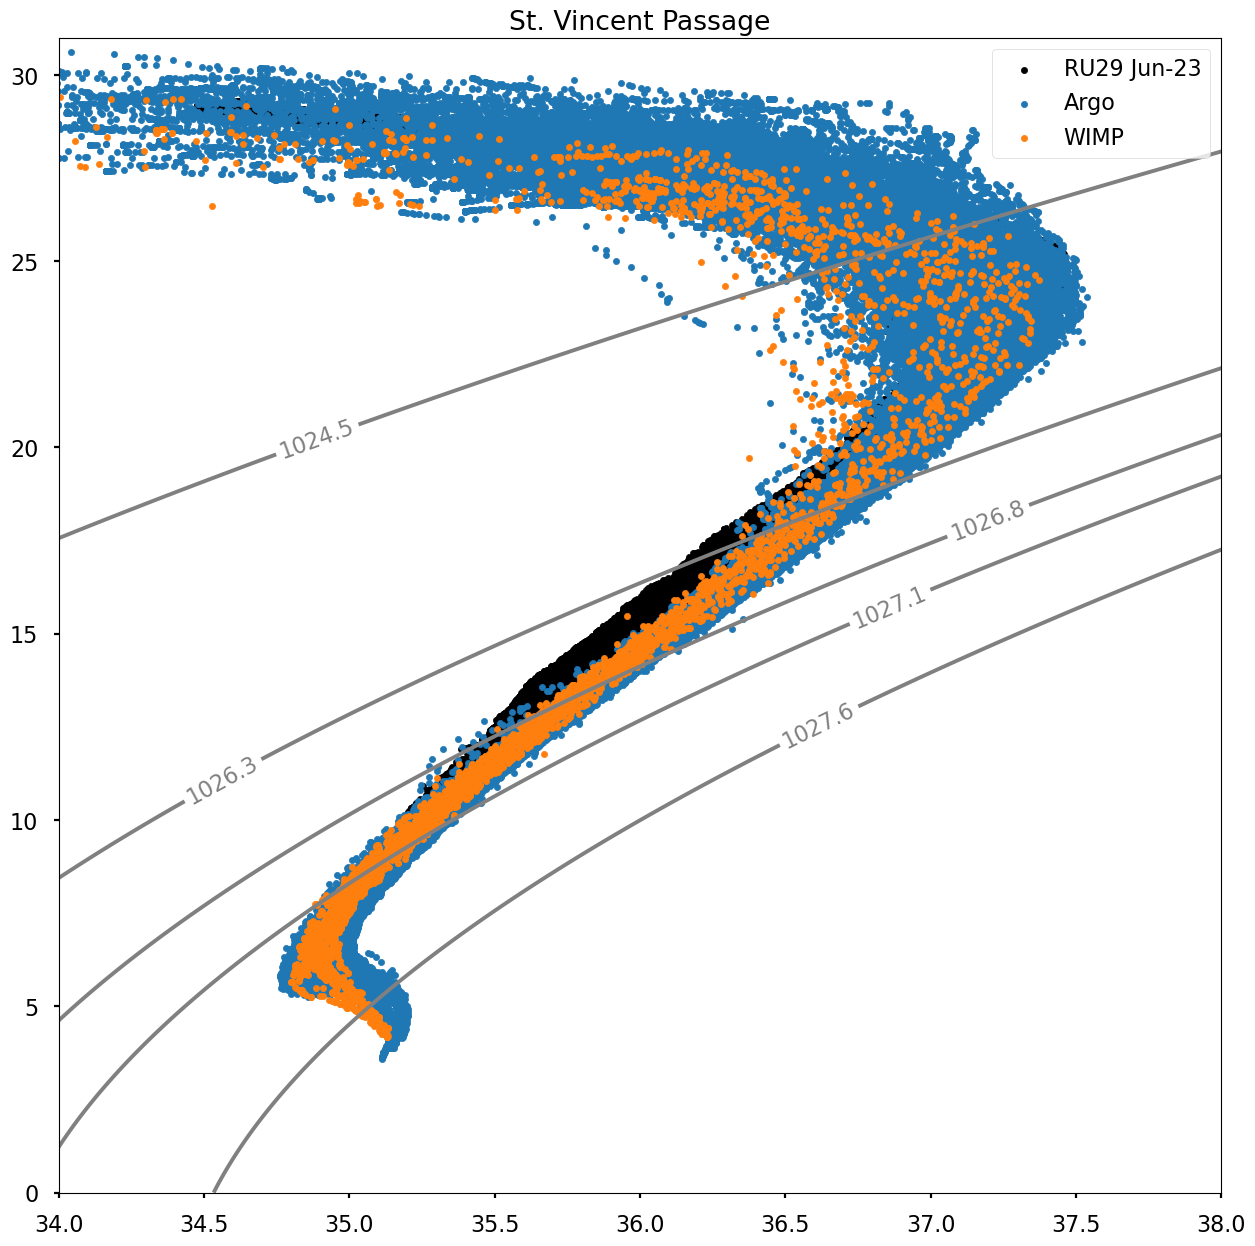

In [207]:
s = 20


plt.figure(figsize=(15,15))

plt.scatter(stv23.absolute_salinity,stv23.conservative_temperature,color='black',s=s,label='RU29 Jun-23')

#plt.scatter(stv22.absolute_salinity,stv22.conservative_temperature,color='grey',s=s,label='RU29 Nov-22')

plt.scatter(argo.absolute_salinity,argo.conservative_temperature,s=s,color='tab:blue',label='Argo')

for x in np.arange(0,len(svds.stn_num)):
    for y in np.arange(0,len(svds.time)):
        plt.scatter(svds.salinity[x,y,:],svds.temperature[x,y,:],color='tab:orange',s=s)

plt.scatter(svds.salinity[x,y,:],svds.temperature[x,y,:],color='tab:orange',s=s,label='WIMP')


plt.legend()
plt.title('St. Vincent Passage')
plt.xlim(34,38)


######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
manual_locations = [(34.9, 20), (34.5, 12), (37.2,18), (36.9,15), (36.65,12)]
plt.clabel(cs,levels, fontsize=16,inline=True,fmt='%.1f', manual=manual_locations)





In [157]:
stv23

depth  depth_interpolated  pressure   latitude  longitude  \
811596   622.22986           622.22986    626.80  13.725000 -61.137107   
811597   622.55695           622.55695    627.13  13.724997 -61.137104   
811598         NaN           622.71060       NaN  13.724996 -61.137103   
811599   622.86426           622.86426    627.44  13.724994 -61.137100   
811600   623.18140           623.18140    627.76  13.724991 -61.137097   
...            ...                 ...       ...        ...        ...   
1161942        NaN           314.22864       NaN  13.724976 -61.141063   
1161943  314.37753           314.37753    316.45  13.724978 -61.141064   
1161944  314.68527           314.68527    316.76  13.724985 -61.141067   
1161945        NaN           314.83914       NaN  13.724993 -61.141071   
1161946  314.99300           314.99300    317.07  13.724993 -61.141071   

                            time  potential_temperature   salinity  \
811596   2023-06-12T01:01:10.69Z               7.731641  34.829006   
811597   2023-06-12T01:01:12.70Z               7.723743  34.827675   
811598   2023-06-12T01:01:13.30Z                    NaN        NaN   
811599   2023-06-12T01:01:14.71Z               7.708382  34.827780   
811600   2023-06-12T01:01:16.71Z               7.685453  34.829200   
...                          ...                    ...        ...   
1161942  2023-06-17T07:38:57.49Z                    NaN        NaN   
1161943  2023-06-17T07:38:57.97Z              13.044959  35.473827   
1161944  2023-06-17T07:38:59.97Z              13.046113  35.472767   
1161945  2023-06-17T07:39:01.96Z                    NaN        NaN   
1161946  2023-06-17T07:39:01.98Z              13.047766  35.472095   

         oxygen_concentration_shifted                        source_file   u  \
811596                        119.945   ru29-2023-158-0-47-dbd(06750047) NaN   
811597                        119.976   ru29-2023-158-0-47-dbd(06750047) NaN   
811598                            NaN   ru29-2023-158-0-47-dbd(06750047) NaN   
811599                        119.983   ru29-2023-158-0-47-dbd(06750047) NaN   
811600                        119.993   ru29-2023-158-0-47-dbd(06750047) NaN   
...                               ...                                ...  ..   
1161942                       135.504  ru29-2023-158-0-123-dbd(06750123) NaN   
1161943                           NaN  ru29-2023-158-0-123-dbd(06750123) NaN   
1161944                       135.502  ru29-2023-158-0-123-dbd(06750123) NaN   
1161945                       135.494  ru29-2023-158-0-123-dbd(06750123) NaN   
1161946                           NaN  ru29-2023-158-0-123-dbd(06750123) NaN   

          v  absolute_salinity  conservative_temperature       sigma0  
811596  NaN          34.997164                  7.661530  1027.193141  
811597  NaN          34.995829                  7.653660  1027.193249  
811598  NaN                NaN                       NaN          NaN  
811599  NaN          34.995936                  7.638344  1027.195568  
811600  NaN          34.997365                  7.615477  1027.200014  
...      ..                ...                       ...          ...  
1161942 NaN                NaN                       NaN          NaN  
1161943 NaN          35.642818                 12.979338  1026.764246  
1161944 NaN          35.641756                 12.980469  1026.763204  
1161945 NaN                NaN                       NaN          NaN  
1161946 NaN          35.641083                 12.982089  1026.762361  

[350351 rows x 15 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<a list of 5 text.Text objects>

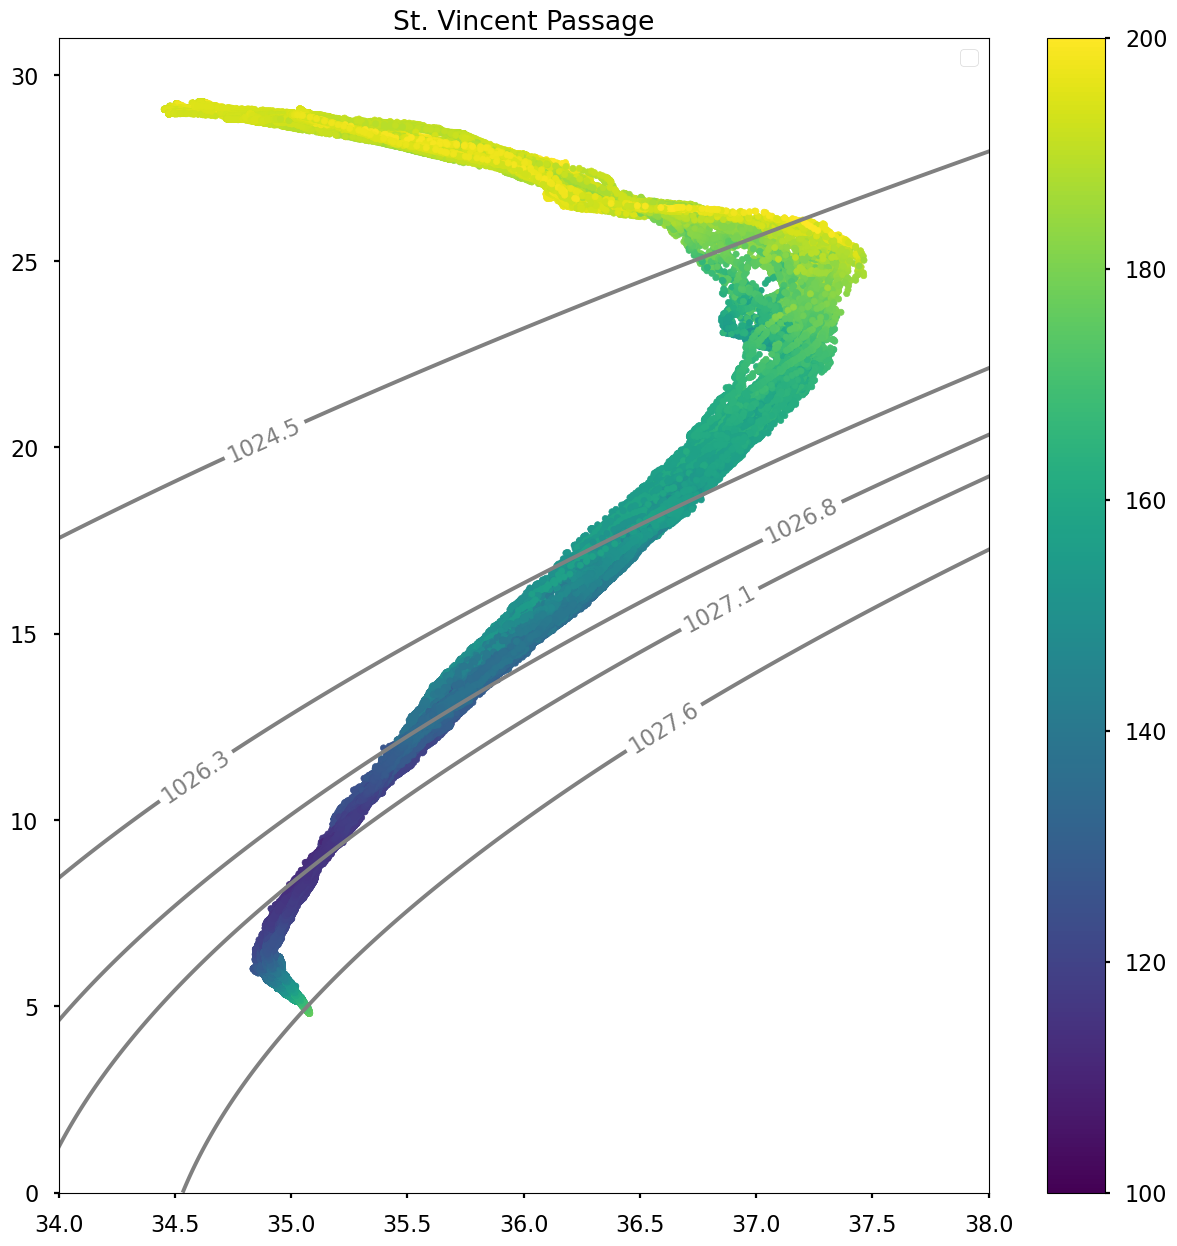

In [158]:
s = 20


plt.figure(figsize=(15,15))


#plt.scatter(argo.absolute_salinity[::10],argo.conservative_temperature[::10],c=argo.depth[::10],s=s,vmin=100,vmax=400)
cmp = plt.scatter(stv23.absolute_salinity,stv23.conservative_temperature,c=stv23.oxygen_concentration_shifted,s=s,vmin=100,vmax=200)


plt.colorbar(cmp)
plt.legend()
plt.title('St. Vincent Passage')
plt.xlim(34,38)


######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
manual_locations = [(34.9, 20), (34.5, 12), (37.2,18), (36.9,15), (36.65,12)]
plt.clabel(cs,levels, fontsize=16,inline=True,fmt='%.1f', manual=manual_locations)





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<a list of 5 text.Text objects>

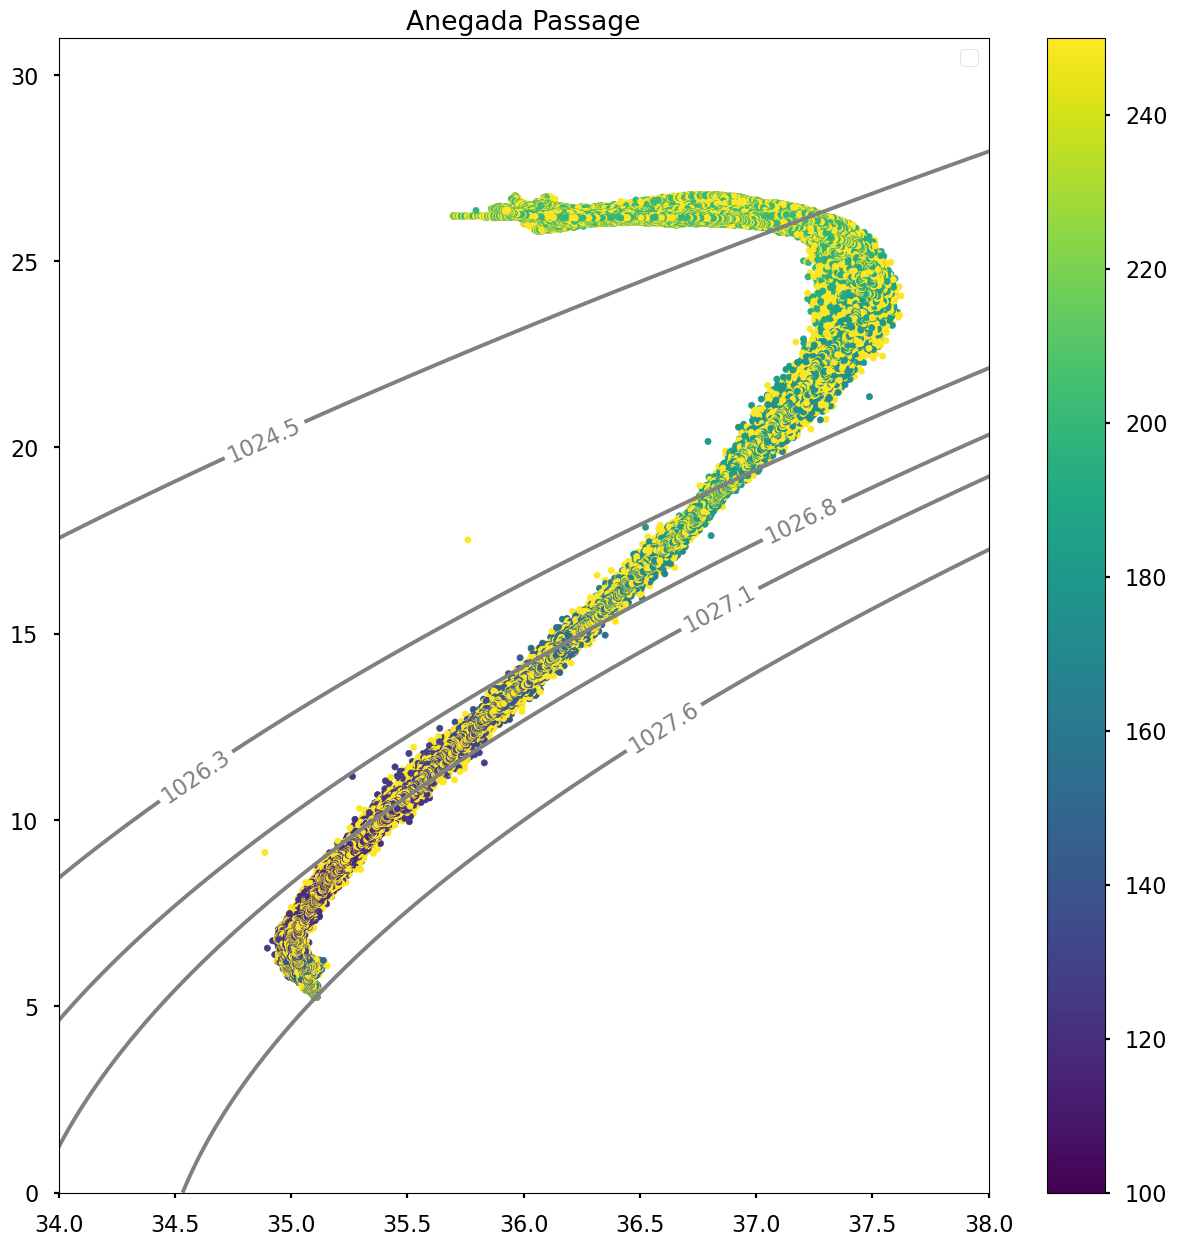

In [168]:
s = 20


plt.figure(figsize=(15,15))


#plt.scatter(argo.absolute_salinity[::10],argo.conservative_temperature[::10],c=argo.depth[::10],s=s,vmin=100,vmax=400)
cmp = plt.scatter(ru29_2022.absolute_salinity,ru29_2022.conservative_temperature,c=ru29_2022.oxygen_concentration_shifted,s=s,vmin=100,vmax=250)


plt.colorbar(cmp)
plt.legend()
plt.title('Anegada Passage')
plt.xlim(34,38)


######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
manual_locations = [(34.9, 20), (34.5, 12), (37.2,18), (36.9,15), (36.65,12)]
plt.clabel(cs,levels, fontsize=16,inline=True,fmt='%.1f', manual=manual_locations)





(100.0, 225.0)

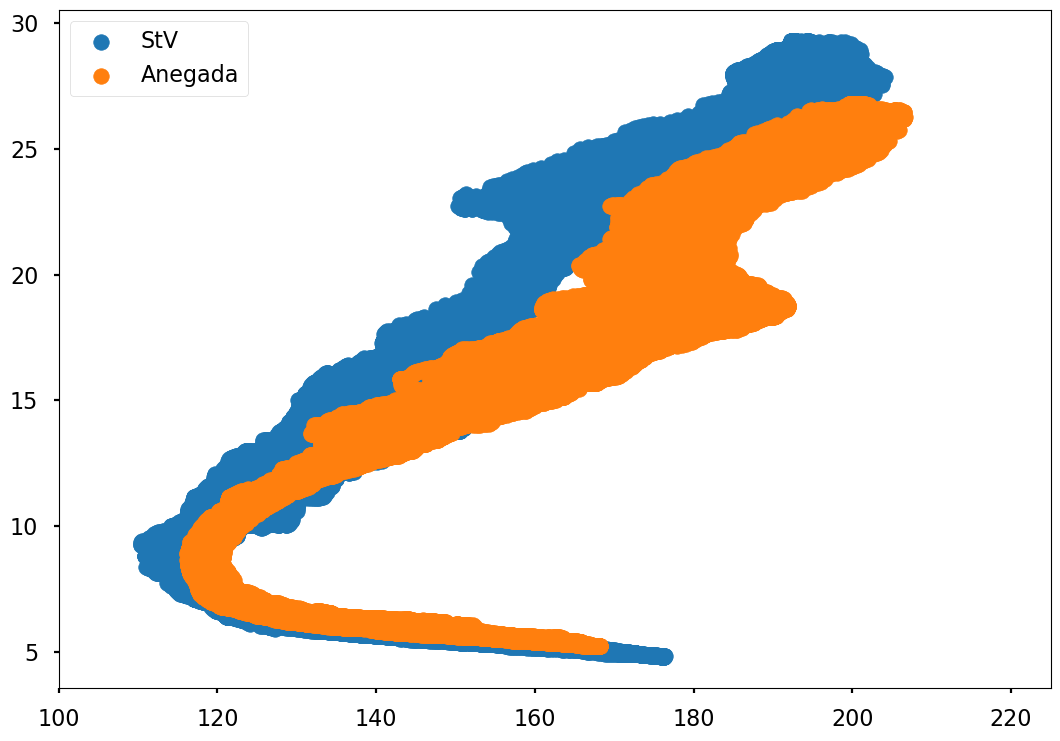

In [177]:
plt.scatter(stv23.oxygen_concentration_shifted,stv23.conservative_temperature,label='StV')
plt.scatter(ru29_2022.oxygen_concentration_shifted,ru29_2022.conservative_temperature,label='Anegada')
plt.legend()
plt.xlim(100,225)

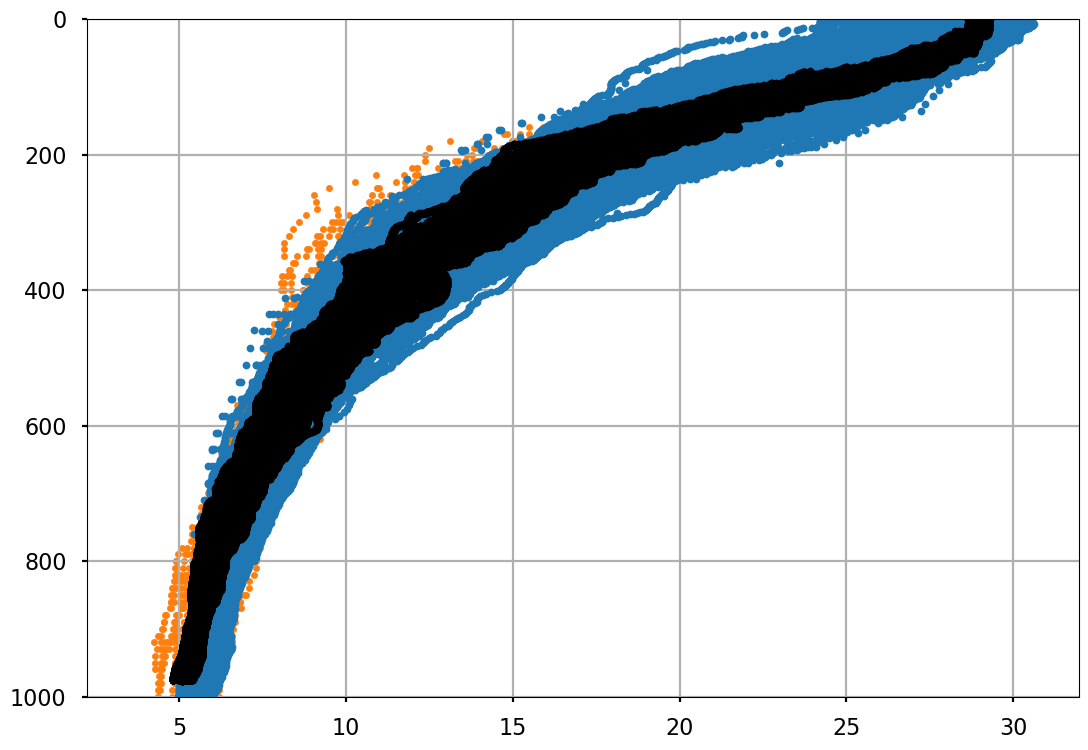

In [129]:
plt.plot(argo.conservative_temperature,argo.depth,'.')
plt.plot(stv23.conservative_temperature,stv23.depth,'.',color='black')

for x in np.arange(0,len(svds.stn_num)):
    for y in np.arange(0,len(svds.time)):
        plt.scatter(svds.temperature[x,y,:],svds.depth,color='tab:orange',s=s)

plt.ylim(1000,0)
plt.grid()

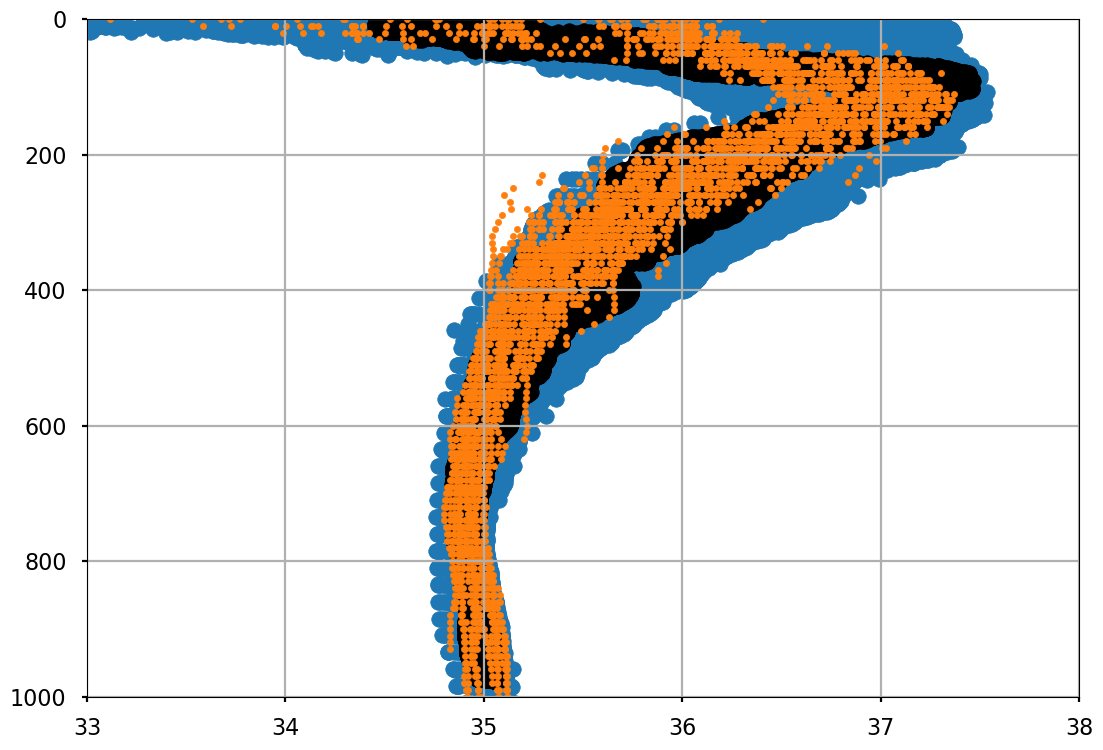

In [136]:
plt.scatter(argo.absolute_salinity,argo.depth)
plt.scatter(stv23.absolute_salinity,stv23.depth,color='black')


for x in np.arange(0,len(svds.stn_num)):
    for y in np.arange(0,len(svds.time)):
        plt.scatter(svds.salinity[x,y,:],svds.depth,color='tab:orange',s=s)


plt.ylim(1000,0)
plt.xlim(33,38)
plt.grid()

In [80]:
stv22

depth  depth_interpolated  pressure   latitude  longitude  \
598108  800.779900          800.779900    807.01  13.724997 -61.137738   
598109  800.363950          800.363950    806.59  13.724994 -61.137733   
598110         NaN          800.156000       NaN  13.724994 -61.137733   
598111  799.948000          799.948000    806.17  13.724991 -61.137728   
598112  799.522100          799.522100    805.74  13.724988 -61.137724   
...            ...                 ...       ...        ...        ...   
801471         NaN            1.605647       NaN  13.722230 -61.142246   
801472    1.461487            1.461487      1.47  13.722232 -61.142248   
801473    1.183110            1.183110      1.19  13.722236 -61.142253   
801474         NaN            1.043921       NaN  13.722239 -61.142257   
801475    0.904732            0.904732      0.91  13.722240 -61.142257   

                           time  potential_temperature   salinity  \
598108  2022-11-27T16:17:31.42Z               6.516212  34.793060   
598109  2022-11-27T16:17:33.42Z               6.516255  34.792600   
598110  2022-11-27T16:17:33.58Z                    NaN        NaN   
598111  2022-11-27T16:17:35.43Z               6.516793  34.792957   
598112  2022-11-27T16:17:37.44Z               6.518129  34.792736   
...                         ...                    ...        ...   
801471  2022-11-30T17:09:37.46Z                    NaN        NaN   
801472  2022-11-30T17:09:38.56Z              27.980453  35.593895   
801473  2022-11-30T17:09:40.56Z              27.971619  35.595510   
801474  2022-11-30T17:09:42.42Z                    NaN        NaN   
801475  2022-11-30T17:09:42.57Z              27.998384  35.591785   

        oxygen_concentration_shifted                        source_file   u  \
598108                       132.715  ru29-2022-320-0-160-dbd(06580160) NaN   
598109                       132.676  ru29-2022-320-0-160-dbd(06580160) NaN   
598110                           NaN  ru29-2022-320-0-160-dbd(06580160) NaN   
598111                       132.565  ru29-2022-320-0-160-dbd(06580160) NaN   
598112                       132.477  ru29-2022-320-0-160-dbd(06580160) NaN   
...                              ...                                ...  ..   
801471                           NaN   ru29-2022-331-1-30-dbd(06600030) NaN   
801472                           NaN   ru29-2022-331-1-30-dbd(06600030) NaN   
801473                           NaN   ru29-2022-331-1-30-dbd(06600030) NaN   
801474                           NaN   ru29-2022-331-1-30-dbd(06600030) NaN   
801475                           NaN   ru29-2022-331-1-30-dbd(06600030) NaN   

         v  absolute_salinity  conservative_temperature       sigma0  
598108 NaN          34.961822                  6.435319  1027.336383  
598109 NaN          34.961359                  6.435410  1027.336007  
598110 NaN                NaN                       NaN          NaN  
598111 NaN          34.961716                  6.435981  1027.336212  
598112 NaN          34.961493                  6.437354  1027.335855  
...     ..                ...                       ...          ...  
801471 NaN                NaN                       NaN          NaN  
801472 NaN          35.762309                 27.961483  1022.848632  
801473 NaN          35.763931                 27.952636  1022.852720  
801474 NaN                NaN                       NaN          NaN  
801475 NaN          35.760189                 27.979660  1022.841122  

[203368 rows x 15 columns]

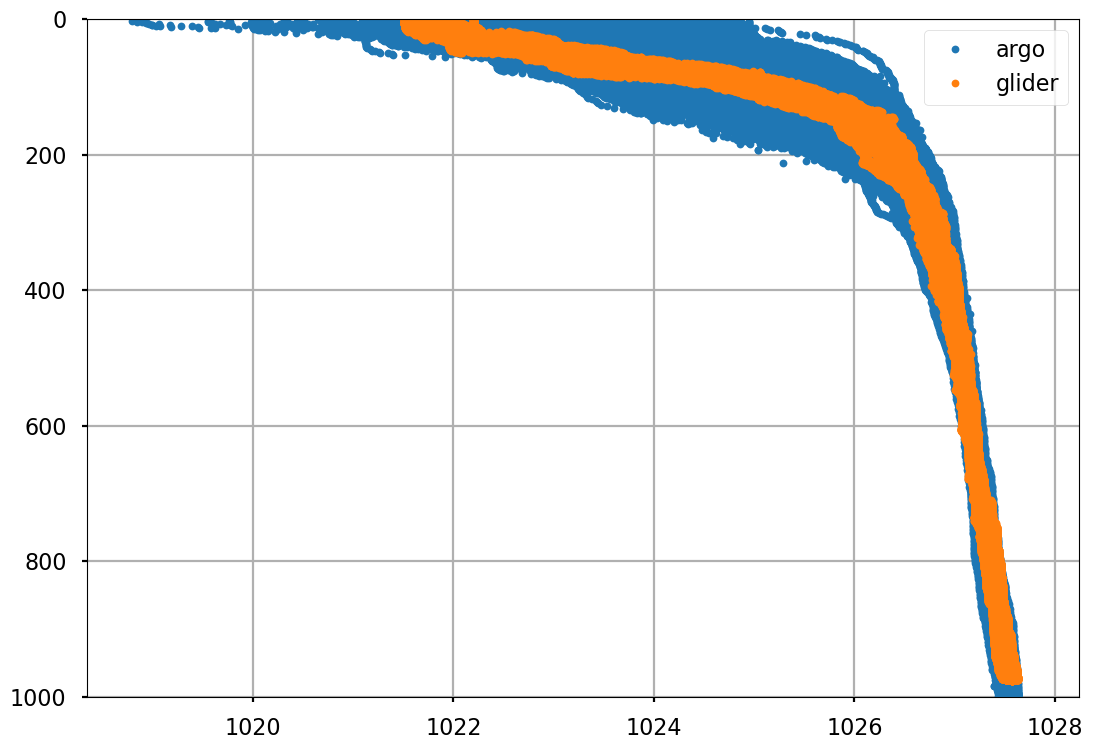

In [93]:

plt.plot(argo.sigma0,argo.depth,'.',label='argo')
plt.plot(stv23.sigma0,stv23.depth,'.',label='glider')
plt.ylim(1000,0)
plt.legend()
plt.grid()

In [110]:
depth_grid = np.arange(0,1001,1)

argo_interp = griddata(argo.depth.values, argo.sigma0.values,depth_grid, method='linear')
gld_interp = griddata(stv23.depth.values, stv23.sigma0.values,depth_grid, method='linear')


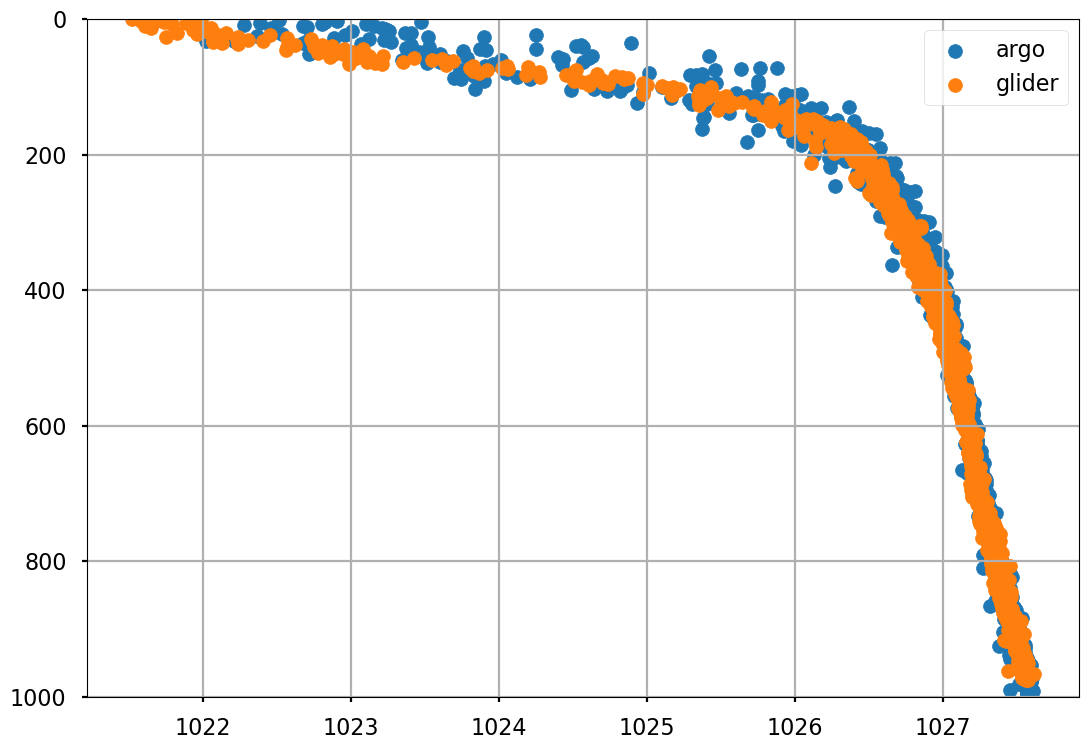

In [111]:

plt.scatter(argo_interp,depth_grid,s=100,label='argo')
plt.scatter(gld_interp,depth_grid,s=100,label='glider')

plt.ylim(1000,0)
plt.legend()
plt.grid()

<a list of 5 text.Text objects>

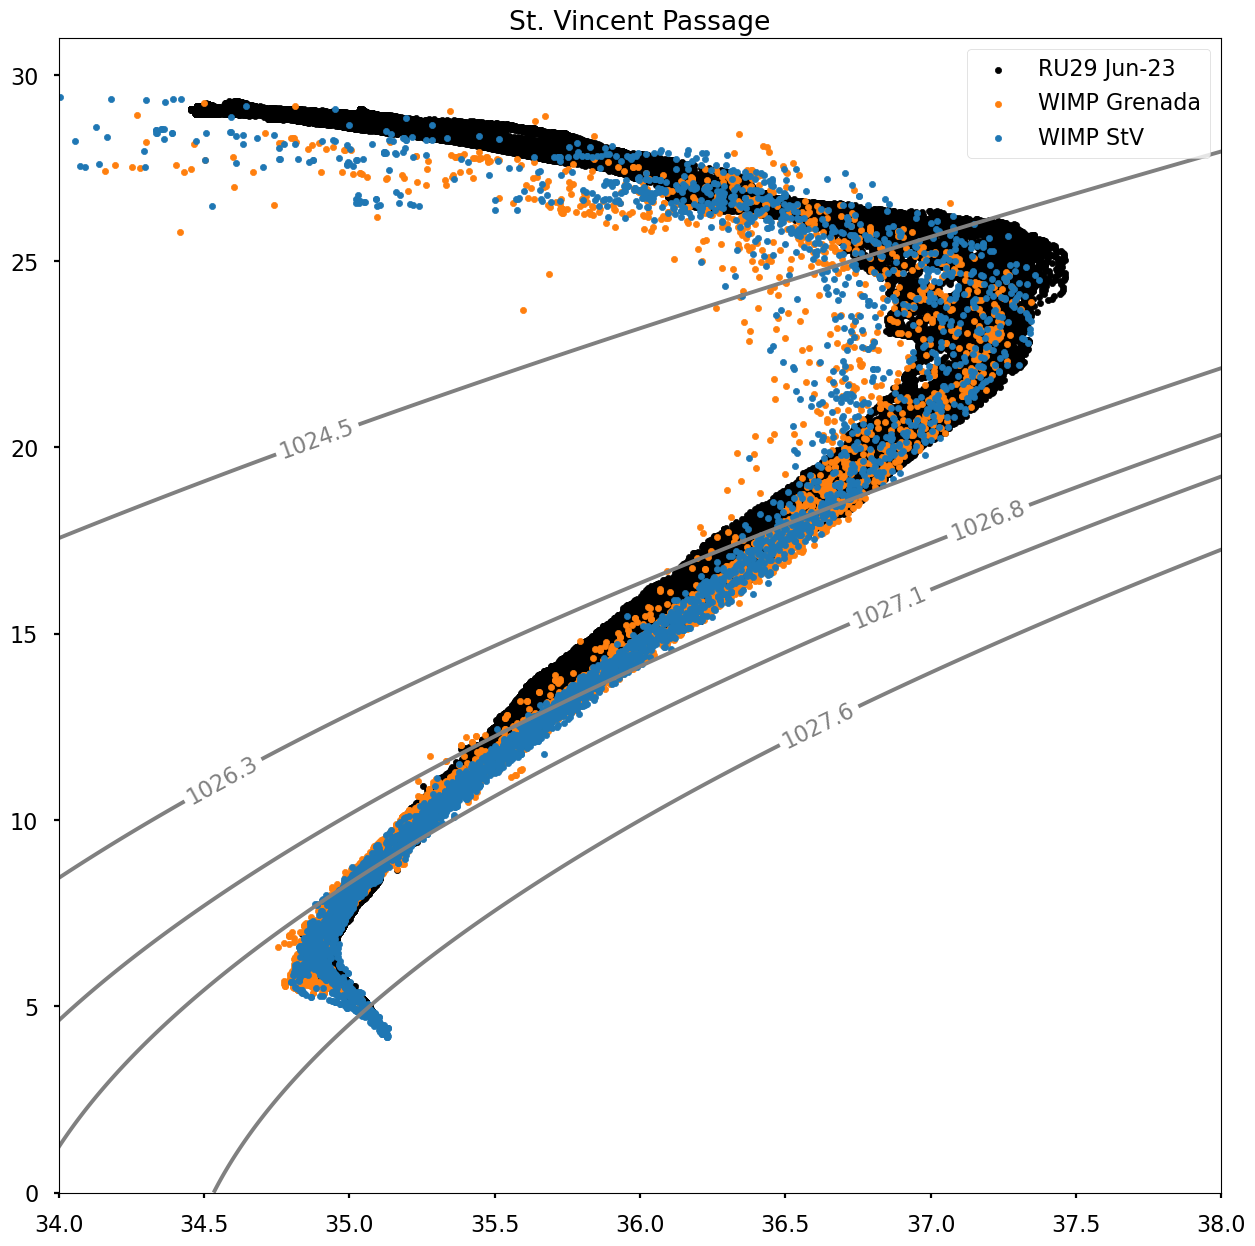

In [156]:
s = 20


plt.figure(figsize=(15,15))

plt.scatter(stv23.absolute_salinity,stv23.conservative_temperature,color='black',s=s,label='RU29 Jun-23')

plt.scatter(grds.salinity[0,0,:],grds.temperature[0,0,:],color='tab:orange',s=s,label='WIMP Grenada')

for x in np.arange(0,len(grds.stn_num)):
    for y in np.arange(0,len(grds.time)):
        plt.scatter(grds.salinity[x,y,:],grds.temperature[x,y,:],color='tab:orange',s=s)

        
        
plt.scatter(svds.salinity[0,0,:],svds.temperature[0,0,:],color='tab:blue',s=s,label='WIMP StV')

for x in np.arange(0,len(svds.stn_num)):
    for y in np.arange(0,len(svds.time)):
        plt.scatter(svds.salinity[x,y,:],svds.temperature[x,y,:],color='tab:blue',s=s)

        

plt.legend()
plt.title('St. Vincent Passage')
plt.xlim(34,38)


######## This plots the contours
mint=1
maxt=30
mins=34
maxs=37.5
tempL=np.linspace(mint-1,maxt+1,399)
salL=np.linspace(mins-1,maxs+1,399)
Tg, Sg = np.meshgrid(tempL,salL)

z=np.linspace(-1000,0,399)
p = gsw.p_from_z(z,lat=0)

sigma_theta = gsw.sigma0(Sg, Tg)+1000

#sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
ind = np.argwhere(sigma_theta > 1015.7)
st_short = sigma_theta[ind]
cs = plt.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=[1024.5,1026.3,1026.8,1027.1,1027.6])
levels = cs.levels
manual_locations = [(34.9, 20), (34.5, 12), (37.2,18), (36.9,15), (36.65,12)]
plt.clabel(cs,levels, fontsize=16,inline=True,fmt='%.1f', manual=manual_locations)





Text(0.5, 1.0, 'Anegada Passage')

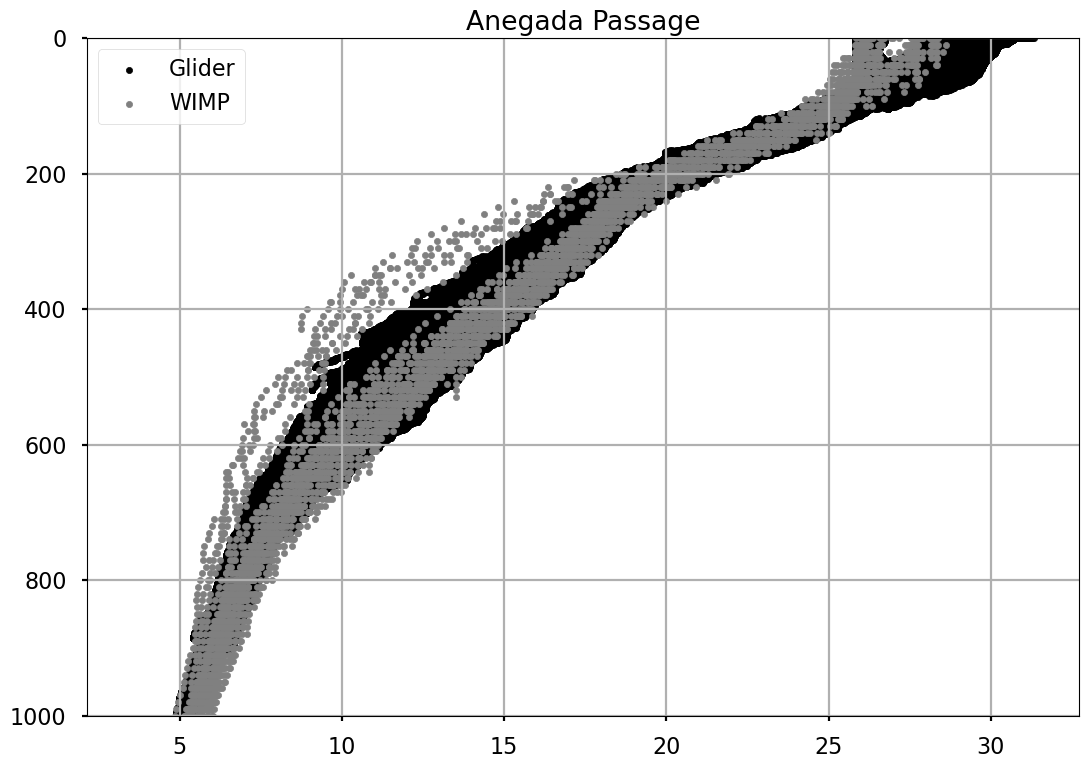

In [206]:

plt.scatter(ru29_2020.conservative_temperature,ru29_2020.depth,color='black',s=s,label='Glider')
plt.scatter(ru29_2021a.conservative_temperature,ru29_2021a.depth,color='black',s=s)
plt.scatter(ru29_2021b.conservative_temperature,ru29_2021b.depth,color='black',s=s)
plt.scatter(ru29_2022.conservative_temperature,ru29_2022.depth,color='black',s=s)

for x in np.arange(0,len(ands.stn_num)):
    for y in np.arange(0,len(ands.time)):
        plt.scatter(ands.temperature[x,y,:],ands.depth,color='grey',s=s)

plt.scatter(ands.temperature[x,y,:],ands.depth,color='grey',s=s,label='WIMP')

plt.legend()
plt.ylim(1000,0)
plt.grid()
plt.title('Anegada Passage')

Text(0.5, 1.0, 'St. Vincent Passage')

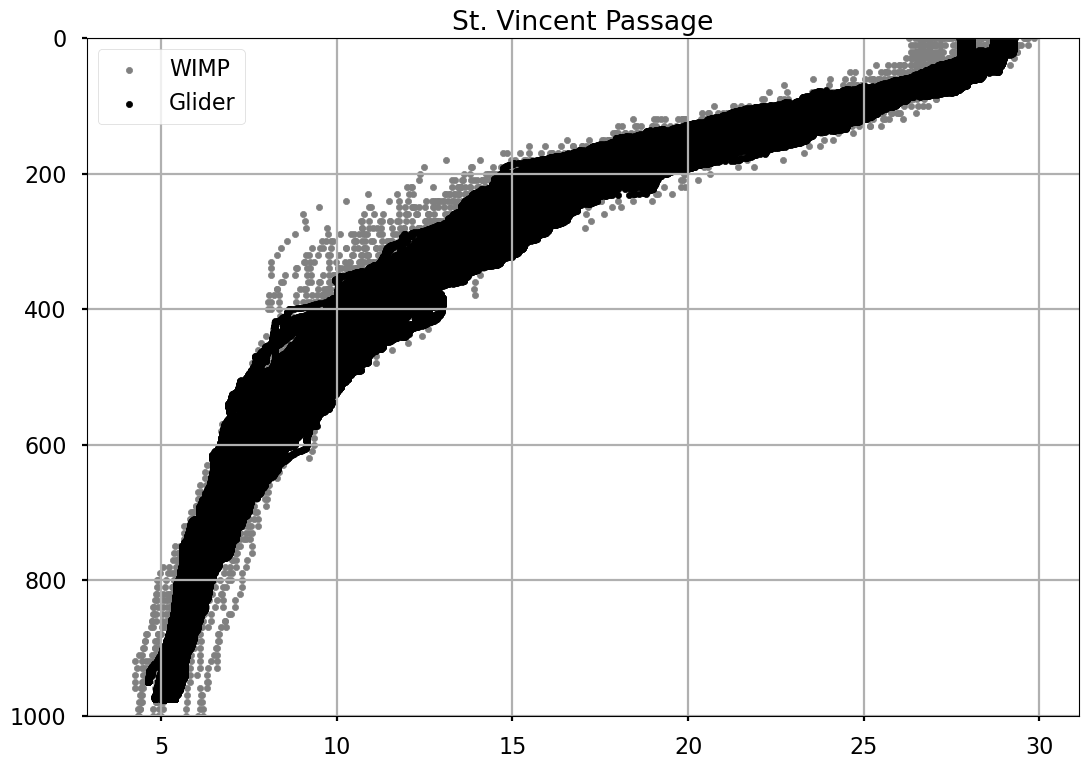

In [196]:

for x in np.arange(0,len(svds.stn_num)):
    for y in np.arange(0,len(svds.time)):
        plt.scatter(svds.temperature[x,y,:],svds.depth,color='grey',s=s)

plt.scatter(svds.temperature[x,y,:],svds.depth,color='grey',s=s,label='WIMP')


plt.scatter(stv23.conservative_temperature,stv23.depth,color='black',s=s,label='Glider')
plt.scatter(stv22.conservative_temperature,stv22.depth,color='black',s=s)

plt.legend()
plt.ylim(1000,0)
plt.grid()
plt.title('St. Vincent Passage')

Text(0.5, 1.0, 'Dominica Passage')

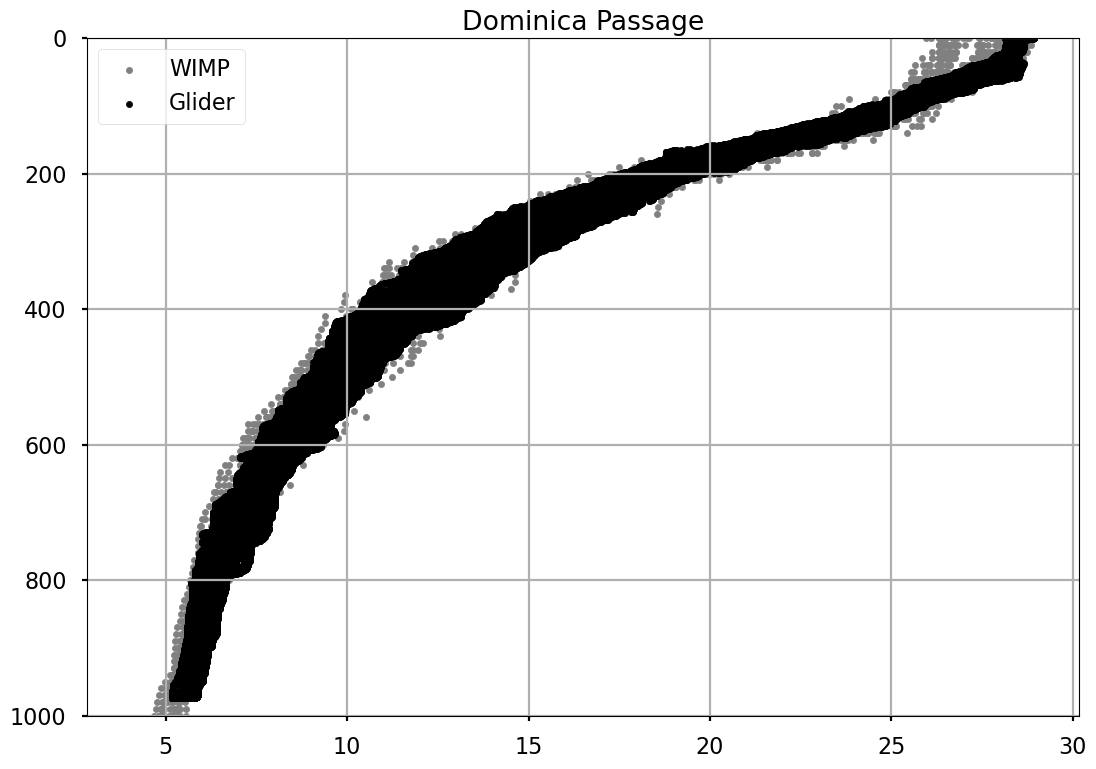

In [199]:

for x in np.arange(0,len(dods.stn_num)):
    for y in np.arange(0,len(dods.time)):
        plt.scatter(dods.temperature[x,y,:],dods.depth,color='grey',s=s)

plt.scatter(dods.temperature[x,y,:],dods.depth,color='grey',s=s,label='WIMP')


plt.scatter(dom23.conservative_temperature,dom23.depth,color='black',s=s,label='Glider')
plt.scatter(dom22.conservative_temperature,dom22.depth,color='black',s=s)

plt.legend()
plt.ylim(1000,0)
plt.grid()
plt.title('Dominica Passage')

Text(0.5, 1.0, 'St. Lucia Passage')

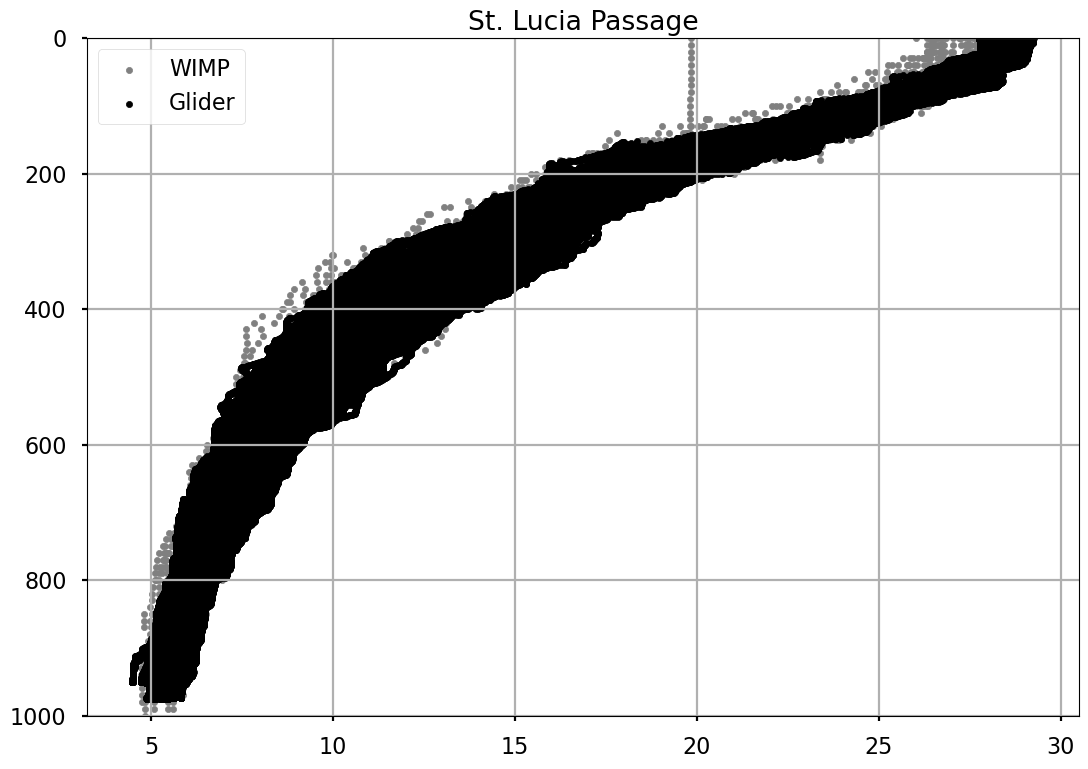

In [203]:

for x in np.arange(0,len(slds.stn_num)):
    for y in np.arange(0,len(slds.time)):
        plt.scatter(slds.temperature[x,y,:],slds.depth,color='grey',s=s)

plt.scatter(slds.temperature[x,y,:],slds.depth,color='grey',s=s,label='WIMP')


plt.scatter(stl23.conservative_temperature,stl23.depth,color='black',s=s,label='Glider')
plt.scatter(stl22.conservative_temperature,stl22.depth,color='black',s=s)

plt.legend()
plt.ylim(1000,0)
plt.grid()
plt.title('St. Lucia Passage')